In [1]:
import pandas as pd
from datetime import datetime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import copy

import osmnx as ox
import igraph as ig

In [2]:
with open("./graph_networkx_CNHK_USA_FINAL_route.pkl", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)
    G = copy.deepcopy(G_loaded)

### Plot based on longitude, latitude

In [3]:
f = open("../data/msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [4]:
#Plot nodes based on location
for node, attributes in G.nodes(data=True):
    try:
        attributes["latitude"] = dict_ports[node]["LocationLatitude"]
        attributes["longitude"] = dict_ports[node]["LocationLongitude"]
    except KeyError:
        raise Warning("Port {0} cannot be found".format(node))
        
position_ports = {k: (attr["longitude"], attr["latitude"]) for k, attr in G.nodes(data=True)}

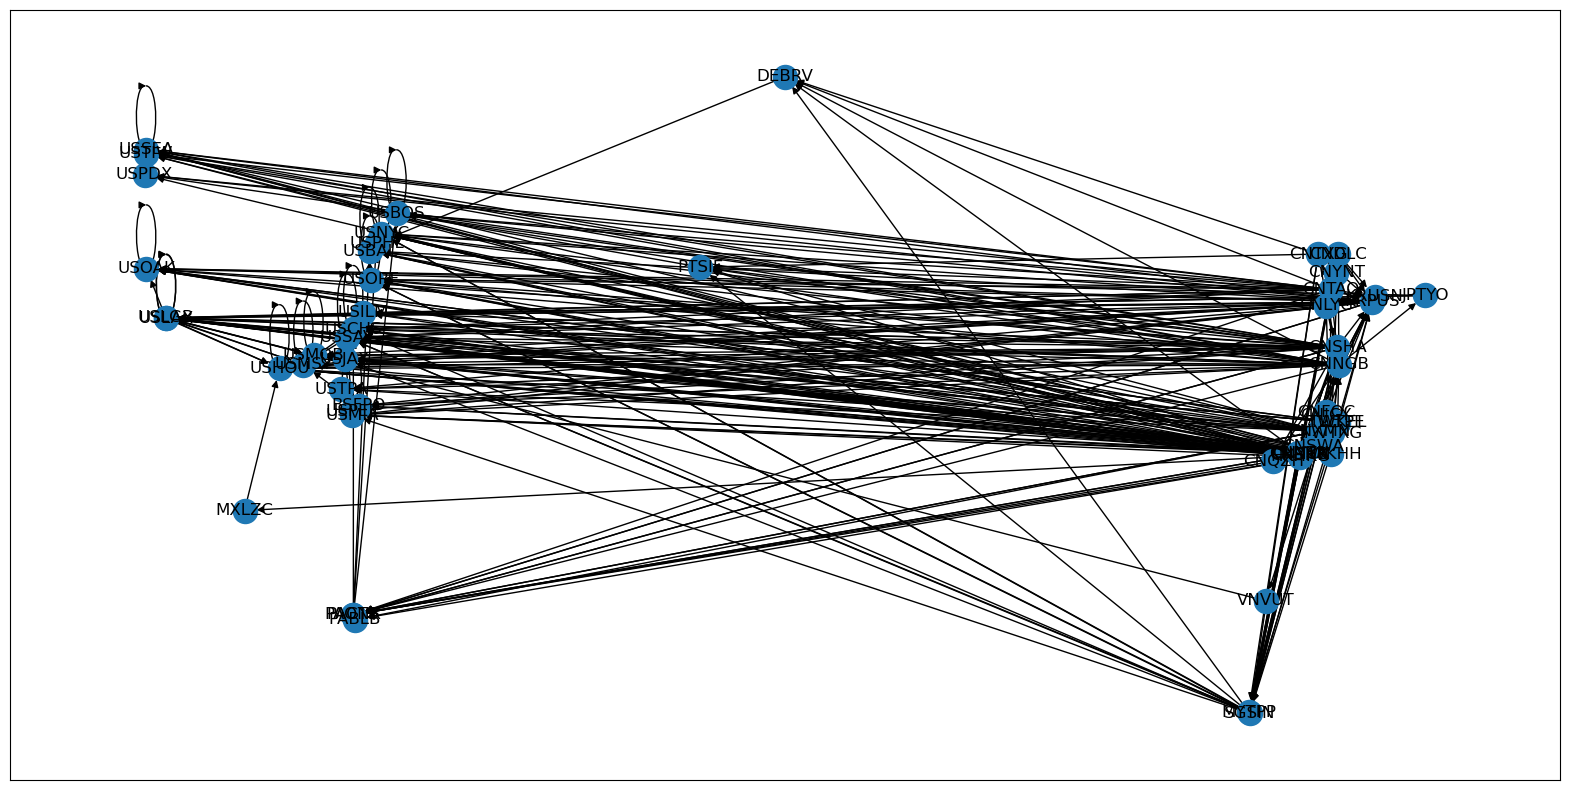

In [5]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=position_ports)
# plt.savefig("./figure/geo_SA_msc_route.png")

In [6]:
#Unweighted shortest-path now -- all edges are 1
#Normalized is True -- so normalized for directed graph
nx.betweenness_centrality(G)

{'CNSHA': 0.01699194702339357,
 'USOAK': 0.0,
 'USMOB': 0.0,
 'USSAV': 0.002623872749658913,
 'CNXMN': 0.03125270373698046,
 'USLAX': 0.0037526482757090722,
 'CNYTN': 0.022663971248876907,
 'USORF': 0.0008075161114993399,
 'CNDLC': 0.005875844397856975,
 'KRPUS': 0.027667132541346375,
 'USBAL': 0.0,
 'USCHS': 0.001357275964194203,
 'USHOU': 0.0,
 'USJAX': 5.823433496389471e-05,
 'KRUSN': 0.0,
 'CNNGB': 0.046863665102658804,
 'USLGB': 0.0034905937683715454,
 'USMIA': 0.0027336860670194,
 'USMSY': 0.0,
 'USSEA': 0.0,
 'USTPA': 0.0008635319956074673,
 'CNFOC': 0.008443978569764731,
 'CNLYG': 0.0,
 'CNTAO': 0.018768926158863265,
 'SGSIN': 0.004153771921067518,
 'CNQZH': 0.0,
 'HKHKG': 0.0639051113107717,
 'CNYNT': 0.0,
 'PTSIE': 0.0007104588865595154,
 'USBOS': 0.0,
 'USILM': 0.0,
 'USNYC': 0.0,
 'USPDX': 0.0,
 'BSFPO': 0.0009234301687131873,
 'USPEF': 0.0,
 'DEBRV': 0.004597184785864032,
 'USPHL': 0.0,
 'VNVUT': 0.0,
 'PACTB': 0.0034391534391534384,
 'CNNSA': 0.0,
 'MYTPP': 0.005026455026

# Analyze the edges 

In [7]:
#Add frequency of the duplicates
for edge in G.edges(data=True):
    etd = edge[2]["etd_origin"]
    eta = edge[2]["eta_destination"]
    time = edge[2]["time_minutes"]
    
    combine = []
    for (o, d, t) in zip(etd, eta, time):
        combine.append((o, d, t))
        
    freq = {}
    for i in combine:
        freq[i] = combine.count(i)
        
    median_time_minutes = np.median([k[2] for k,v in freq.items()])

    G.edges[edge[0], edge[1]]["frequency"] = freq
    G.edges[edge[0], edge[1]]["median_time_minutes"] = median_time_minutes

C:\Users\IvS\AppData\Local\Temp\ipykernel_20860\190393763.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


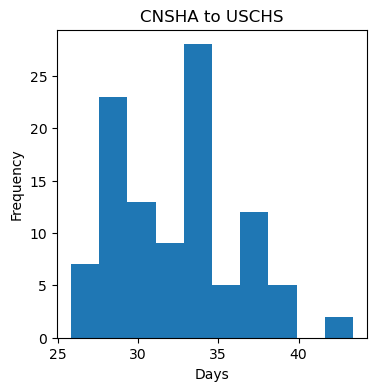

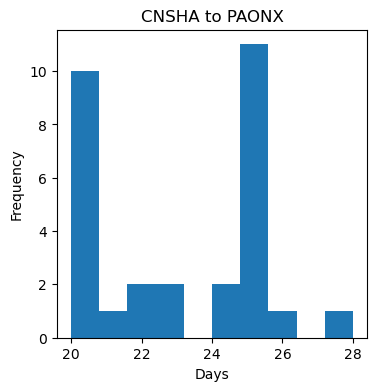

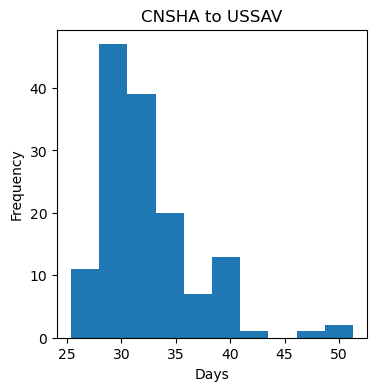

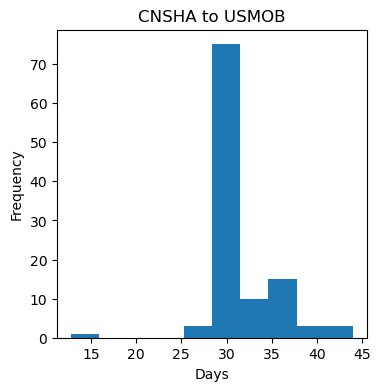

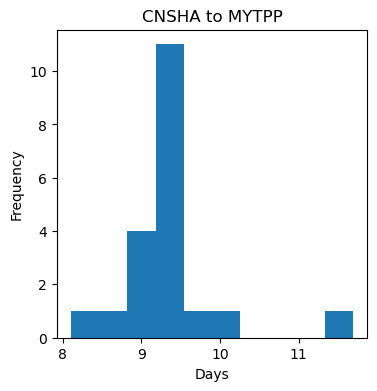

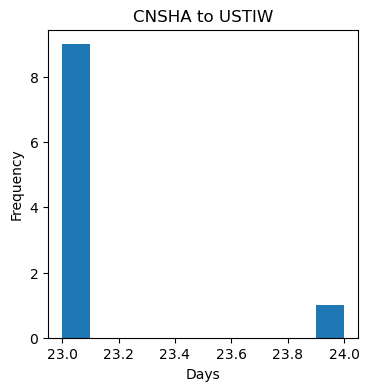

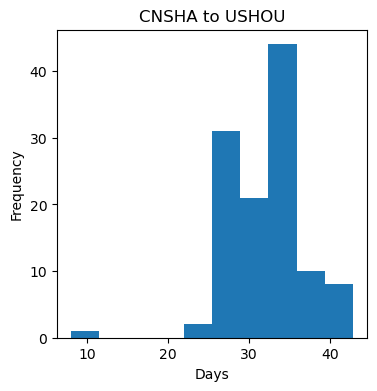

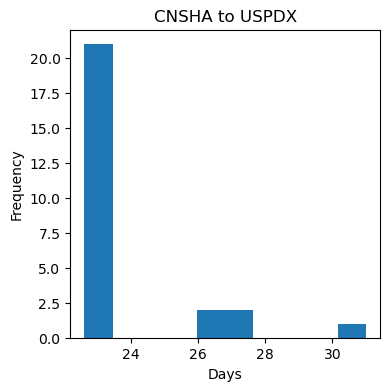

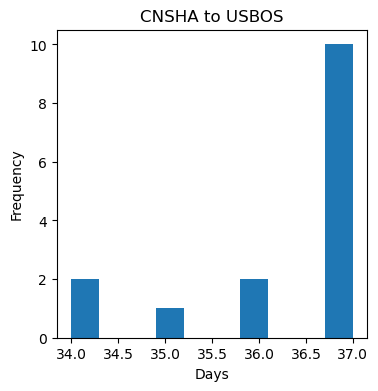

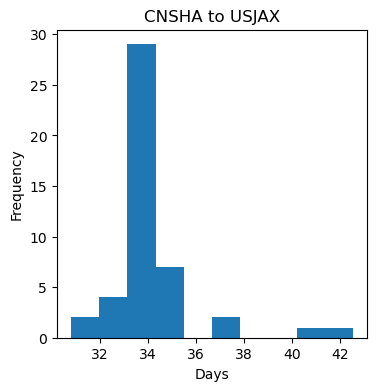

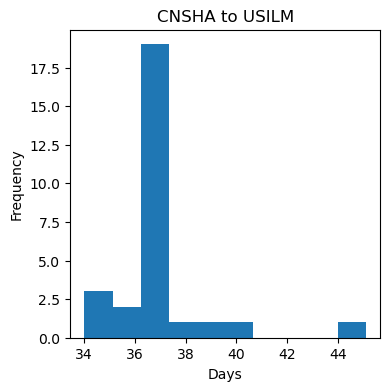

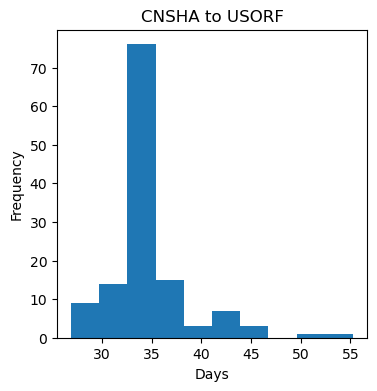

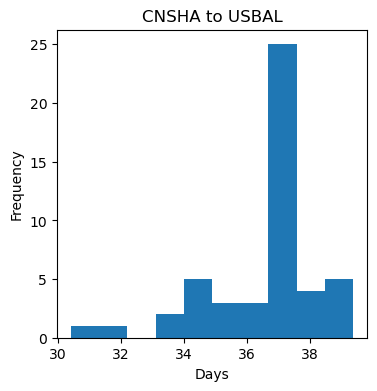

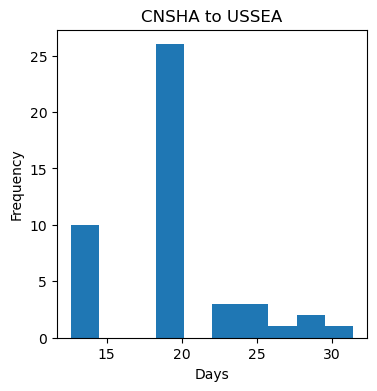

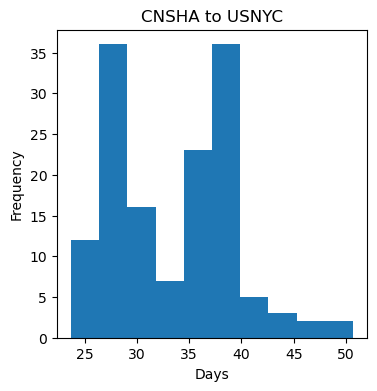

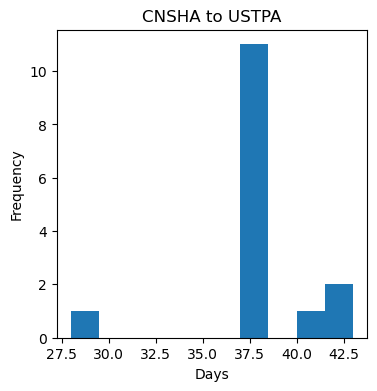

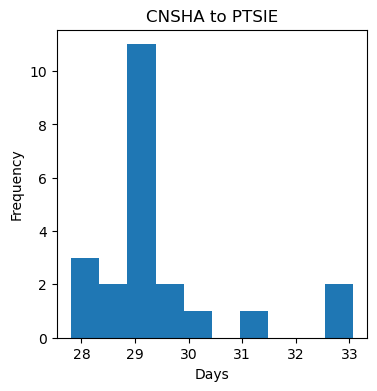

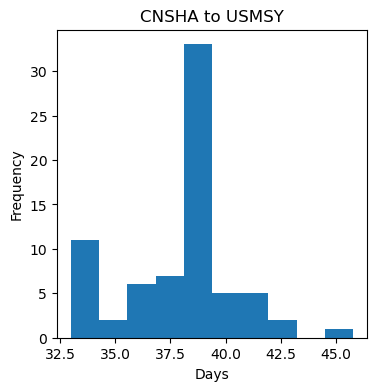

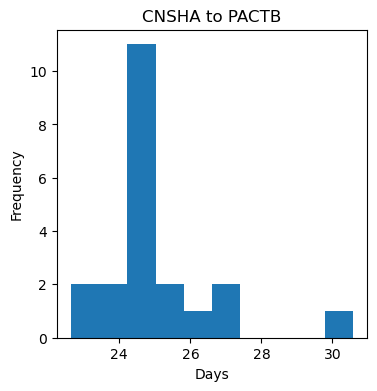

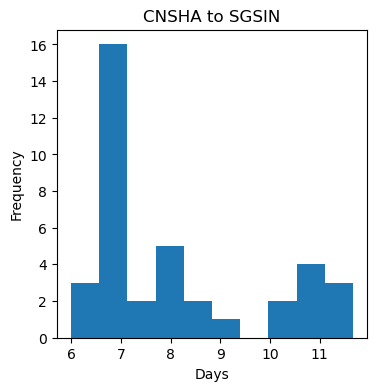

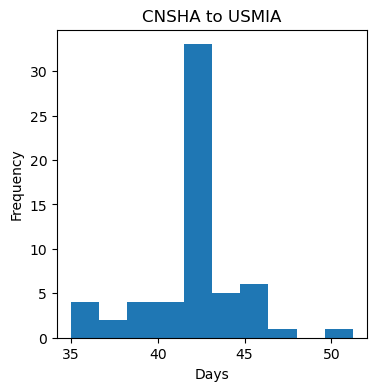

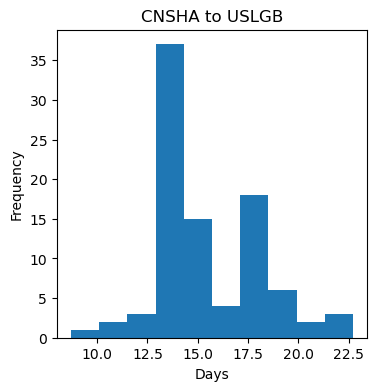

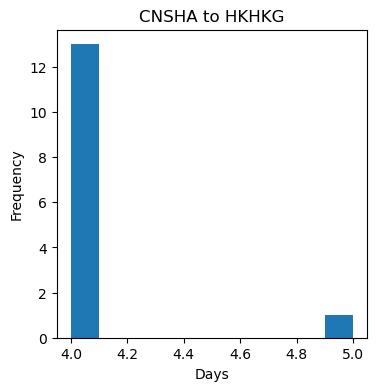

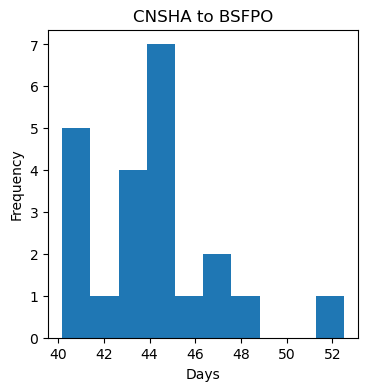

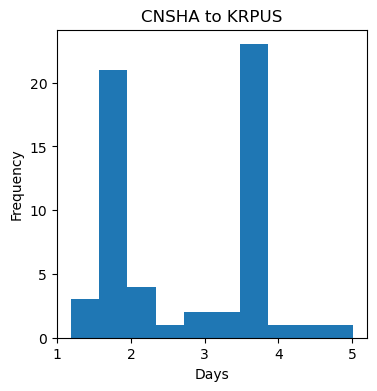

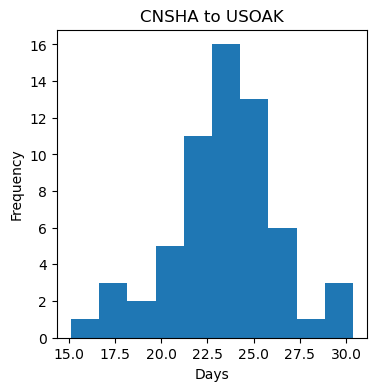

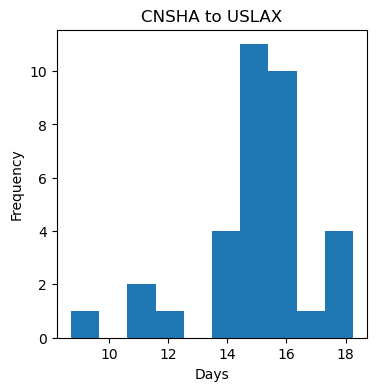

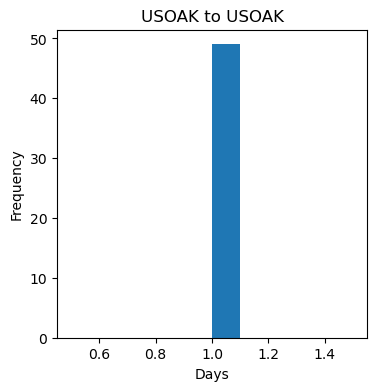

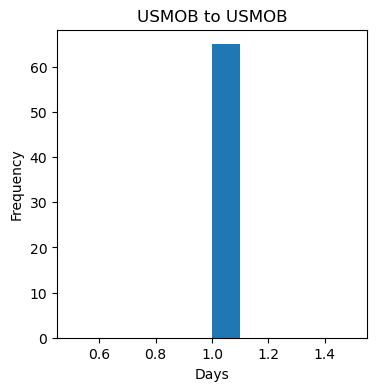

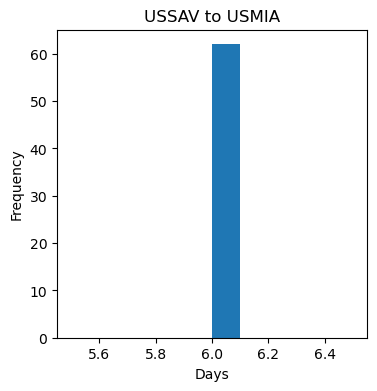

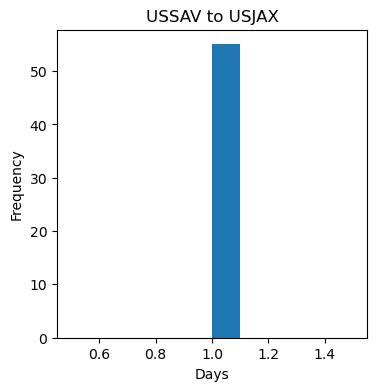

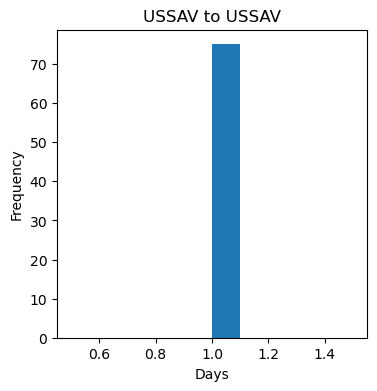

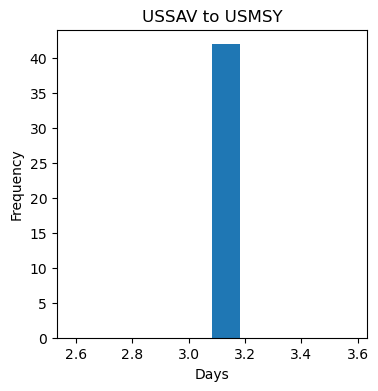

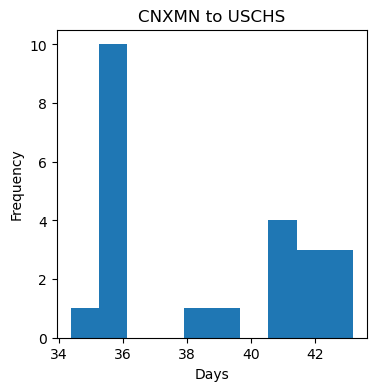

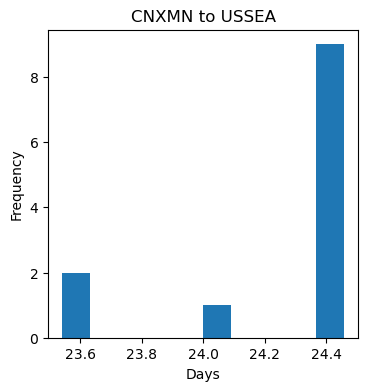

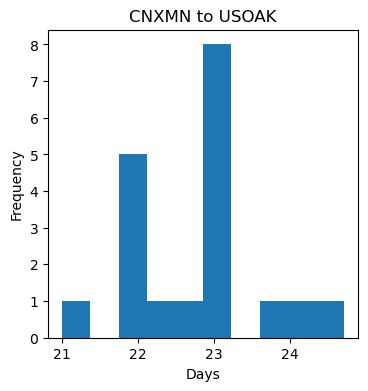

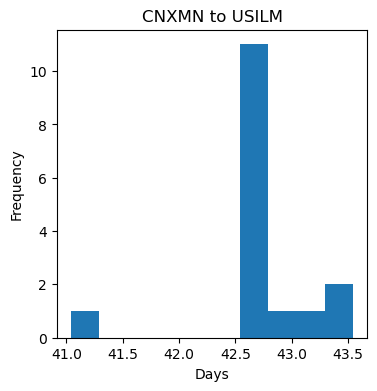

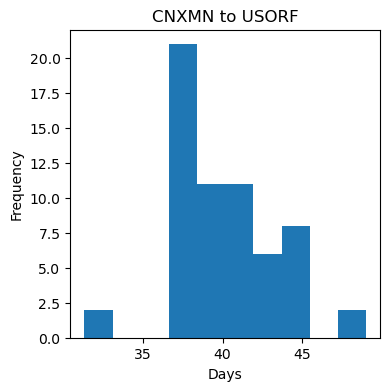

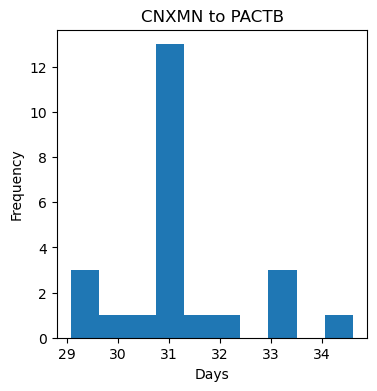

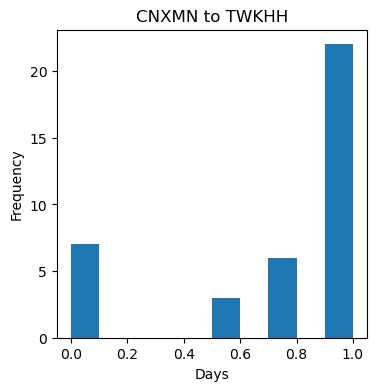

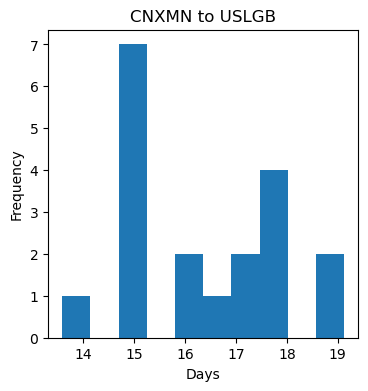

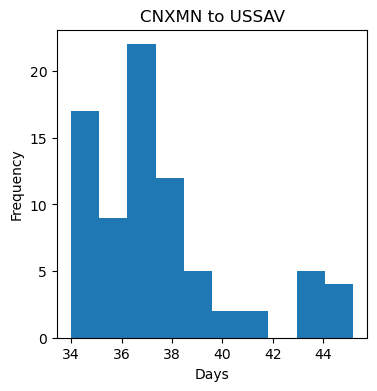

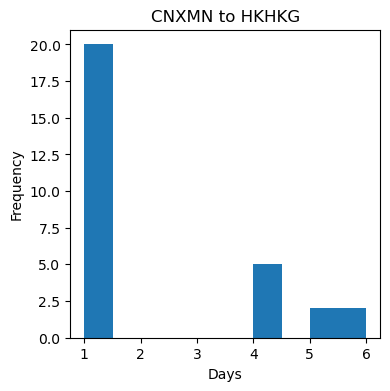

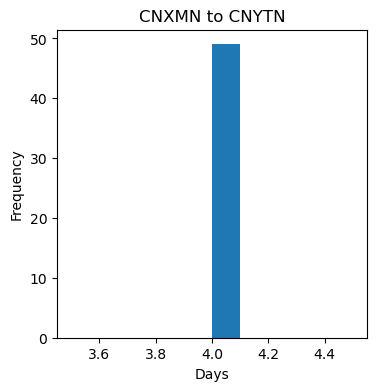

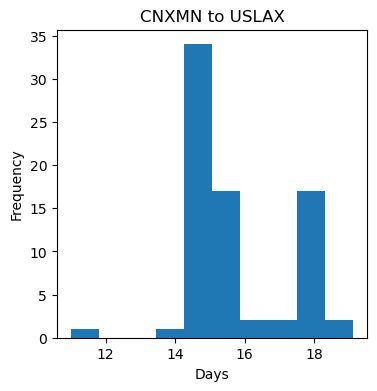

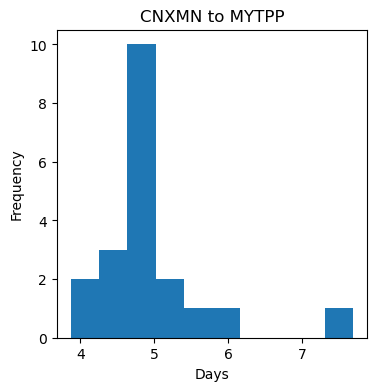

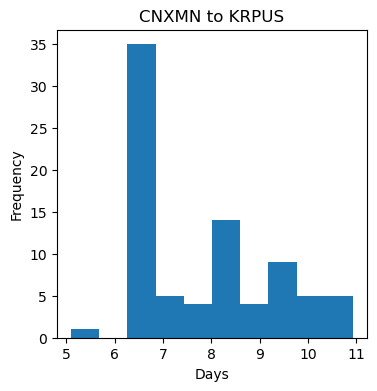

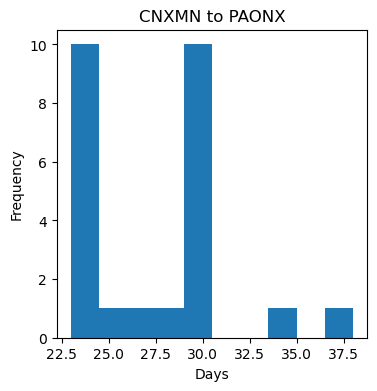

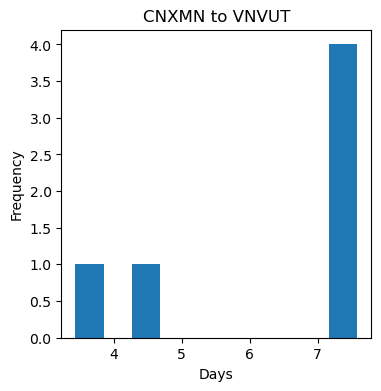

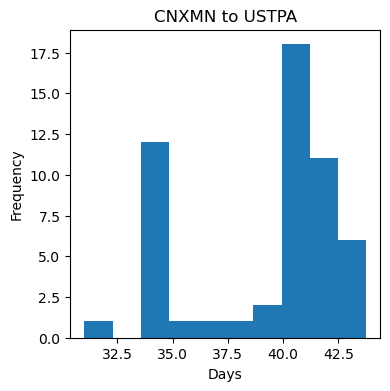

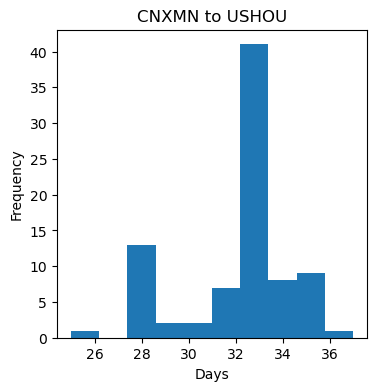

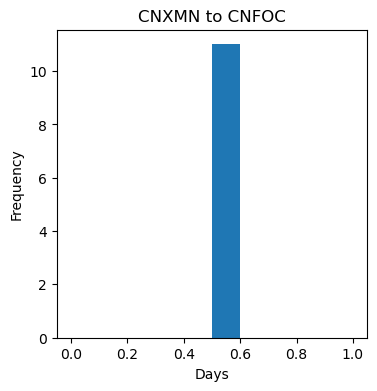

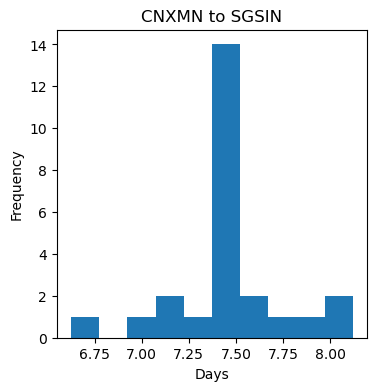

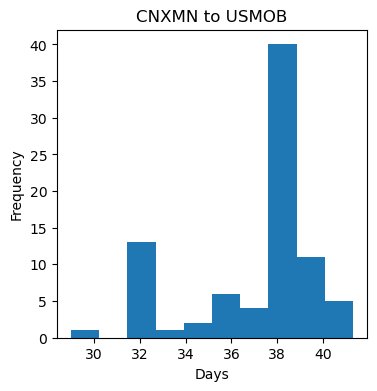

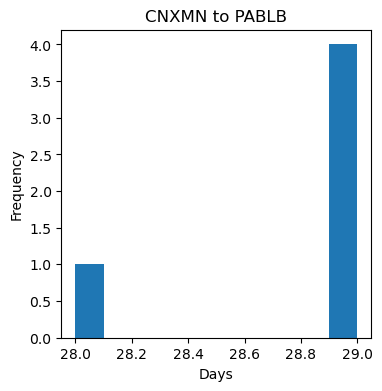

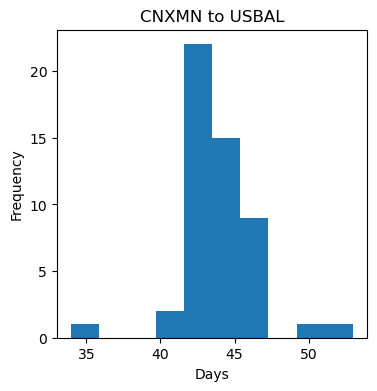

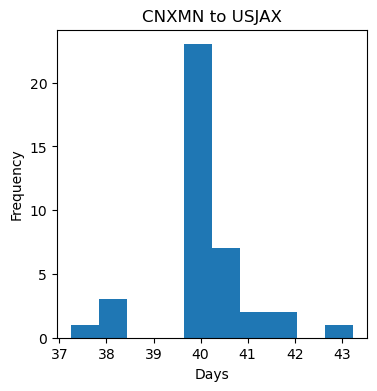

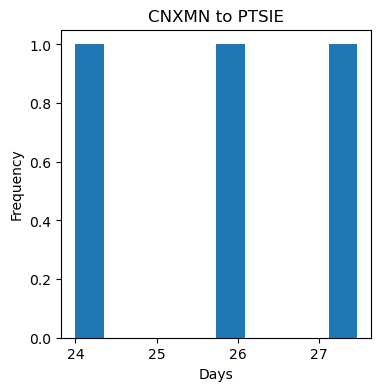

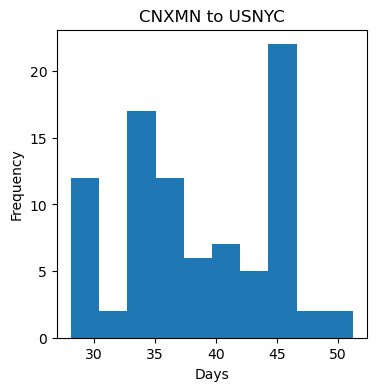

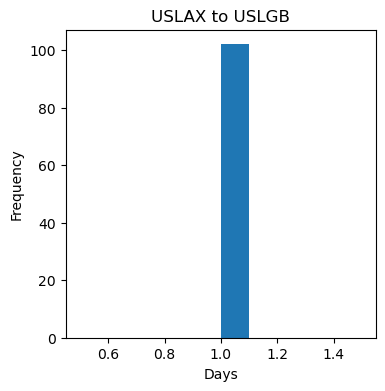

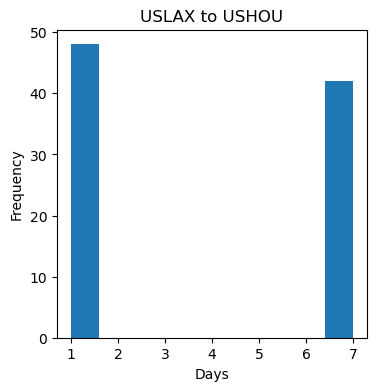

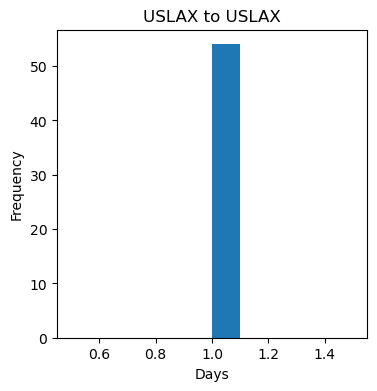

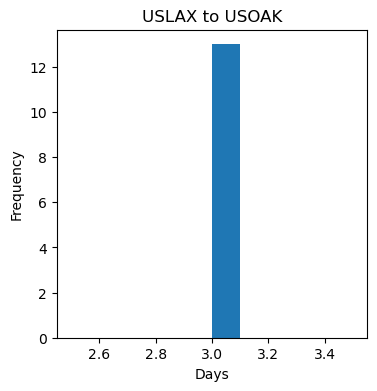

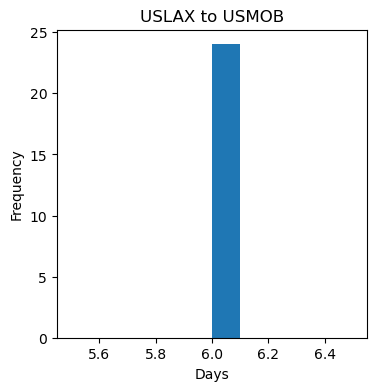

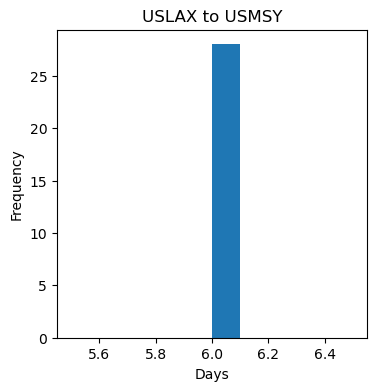

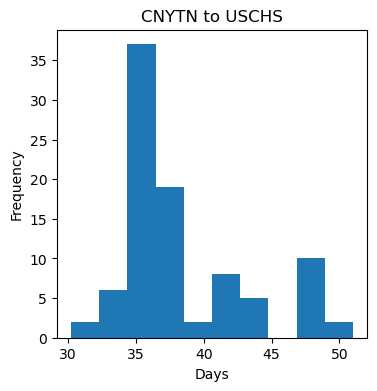

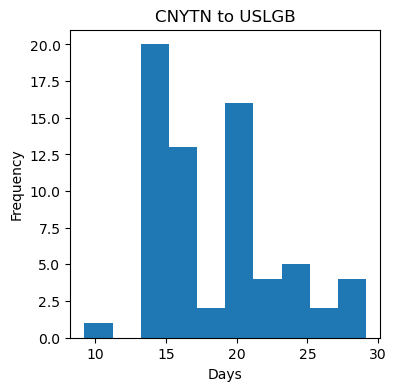

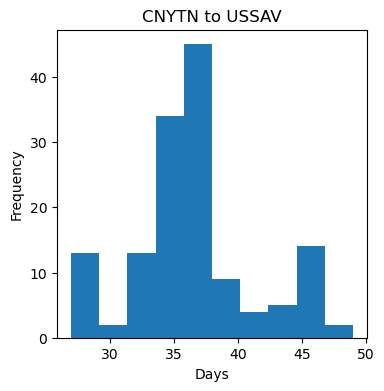

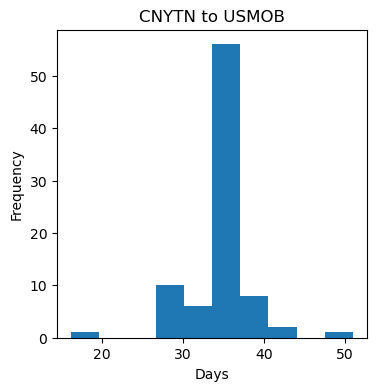

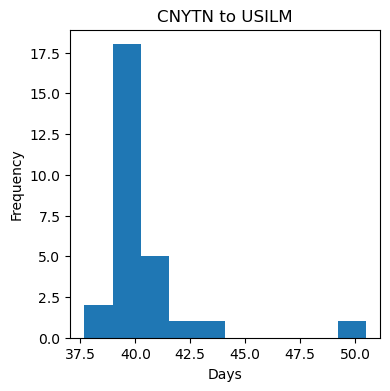

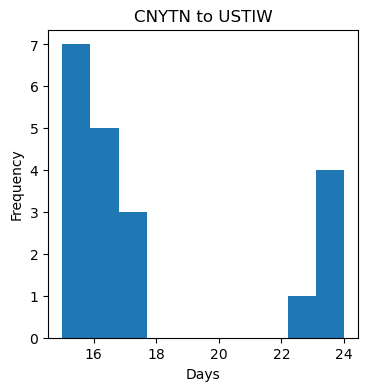

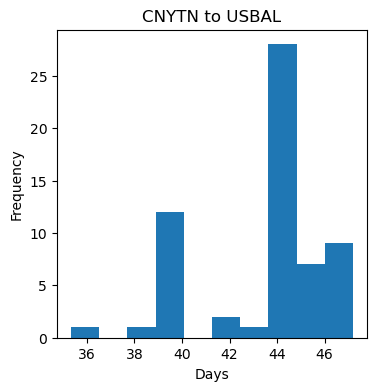

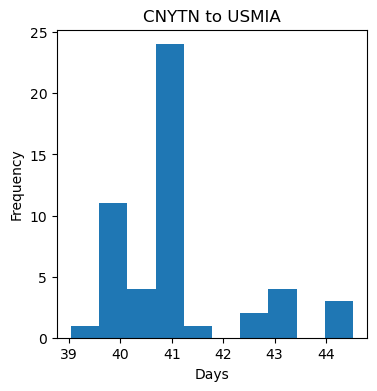

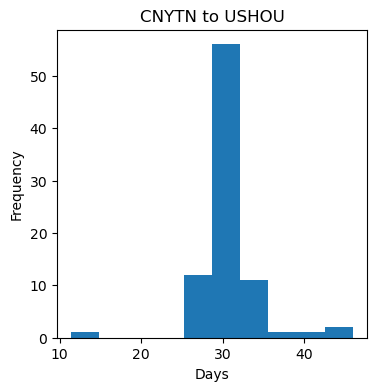

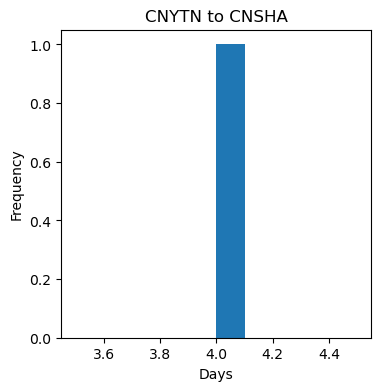

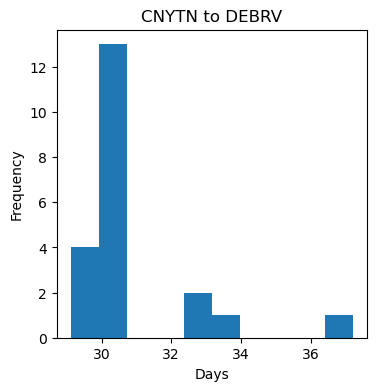

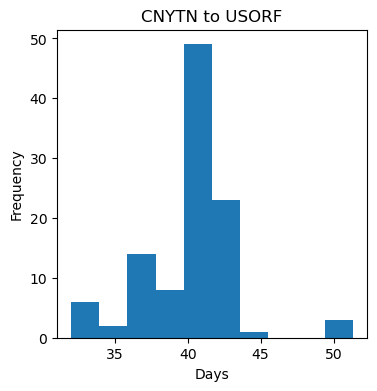

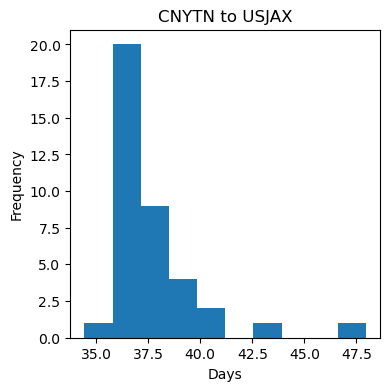

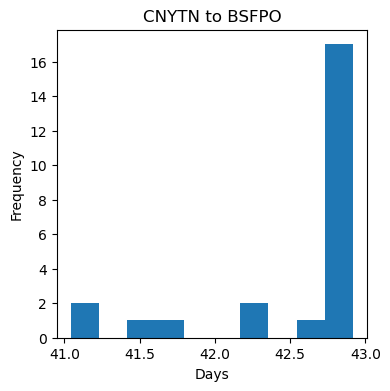

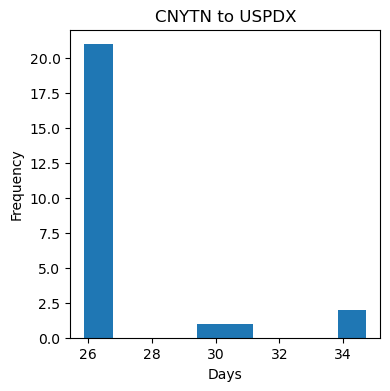

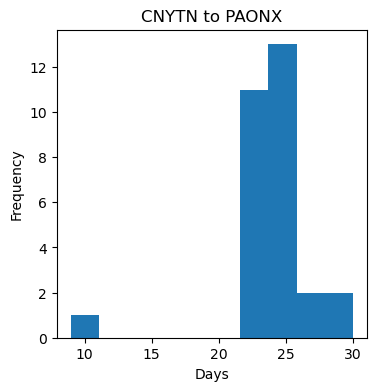

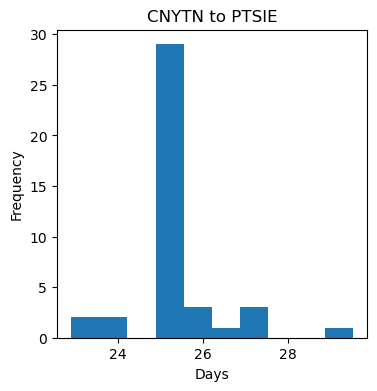

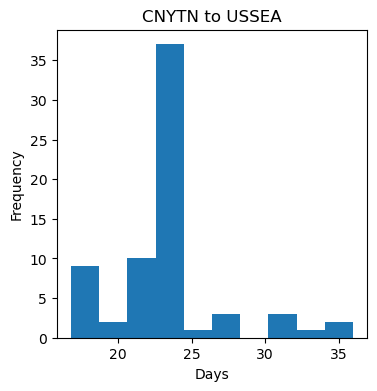

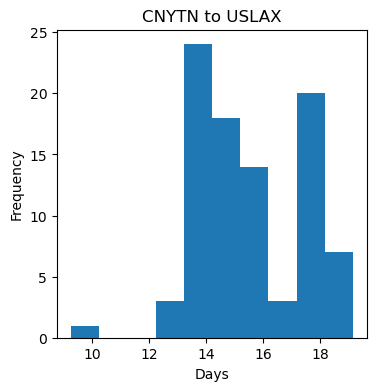

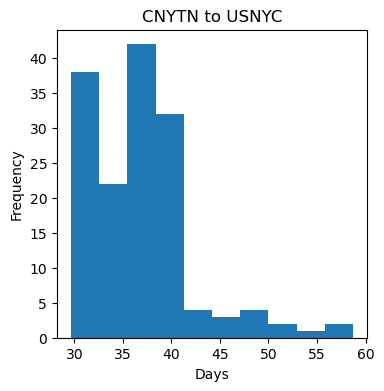

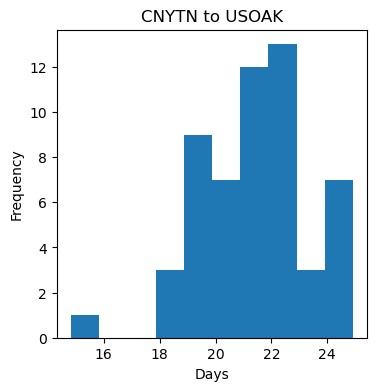

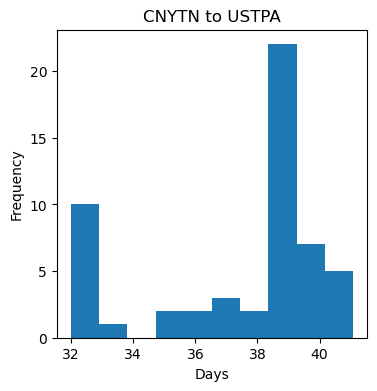

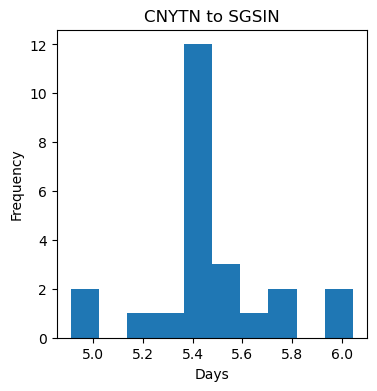

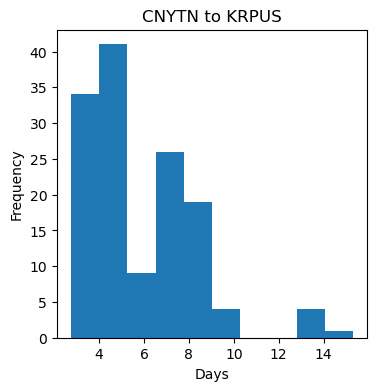

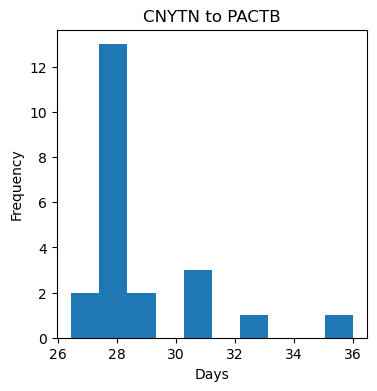

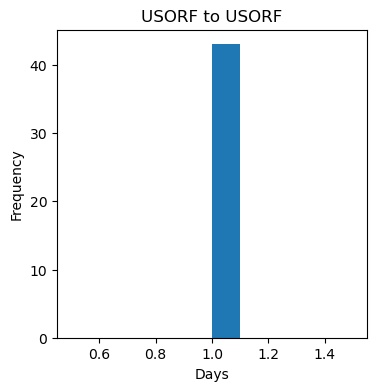

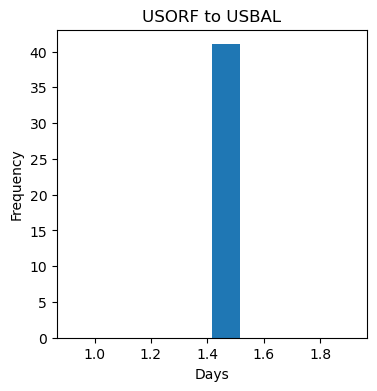

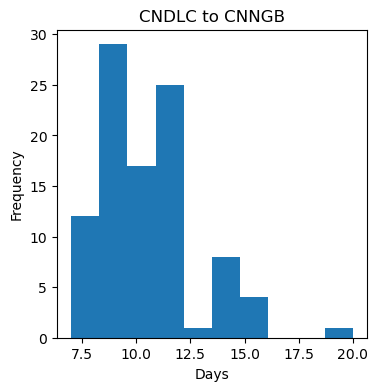

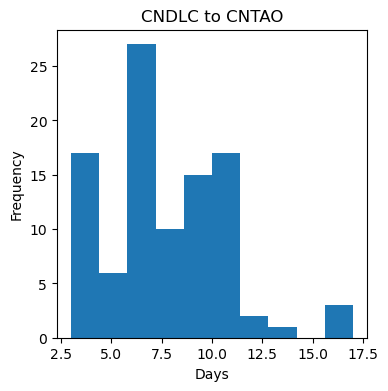

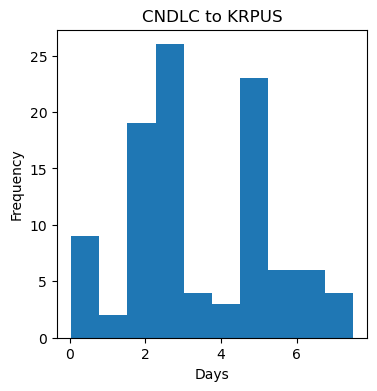

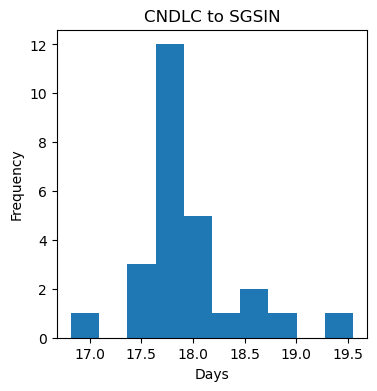

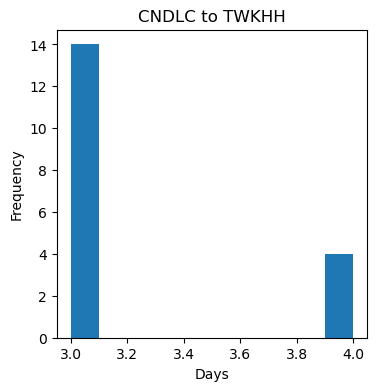

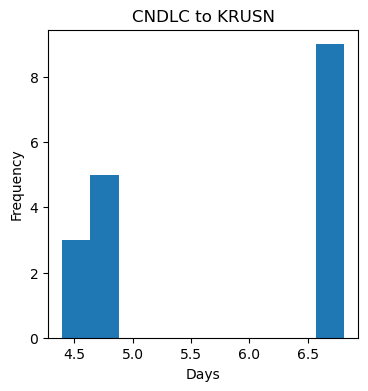

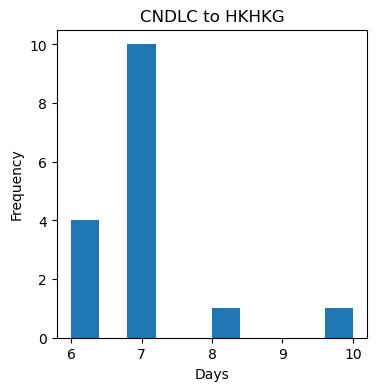

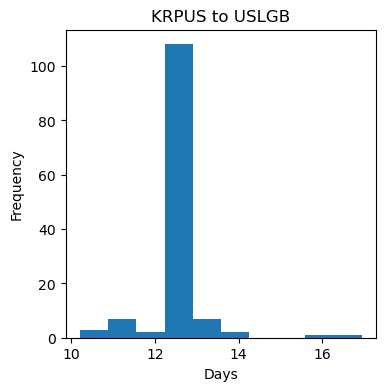

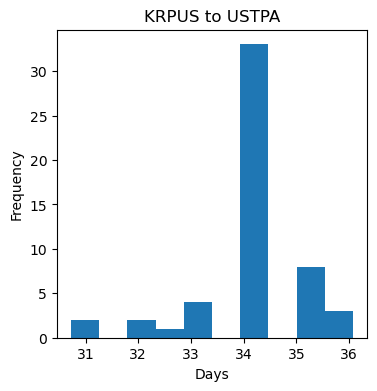

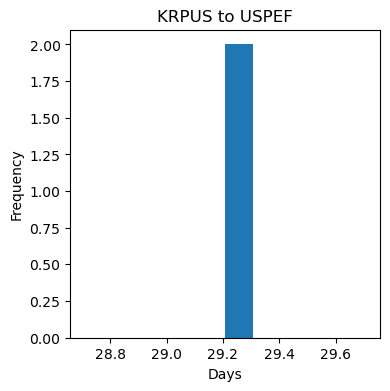

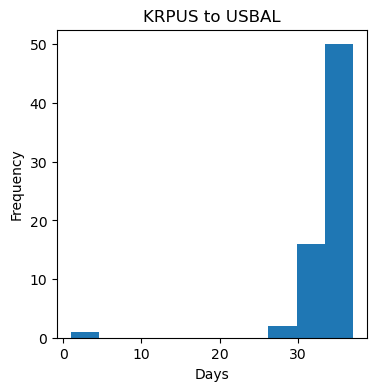

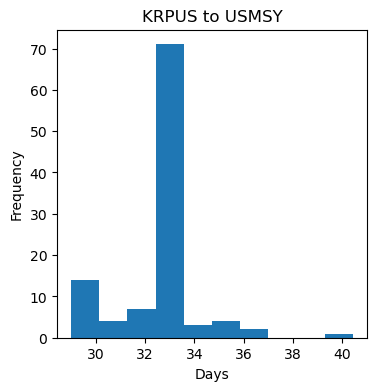

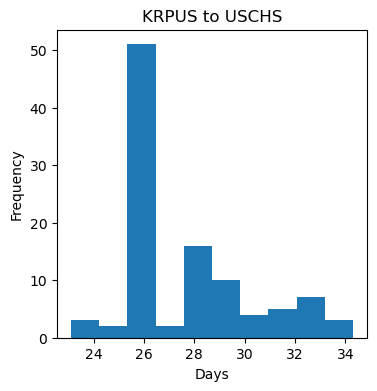

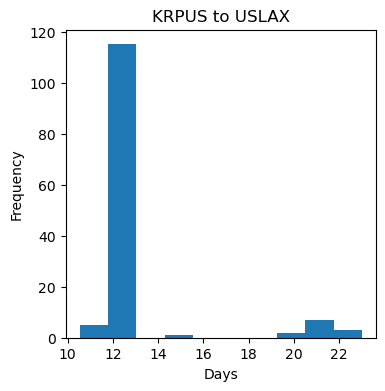

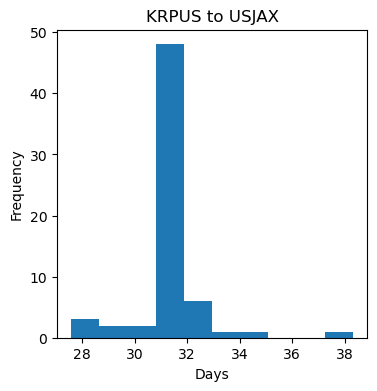

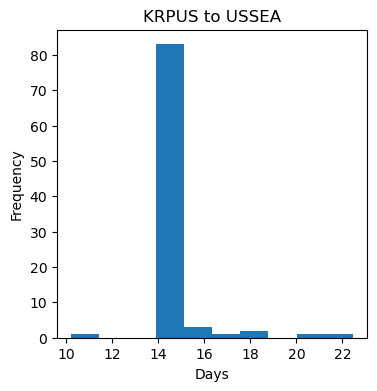

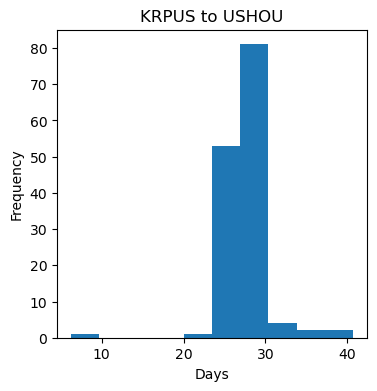

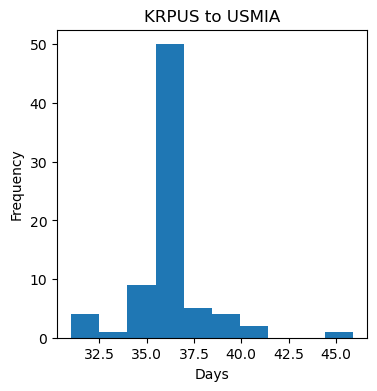

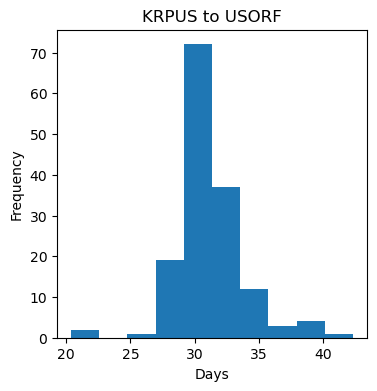

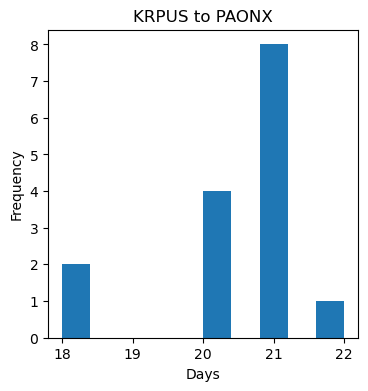

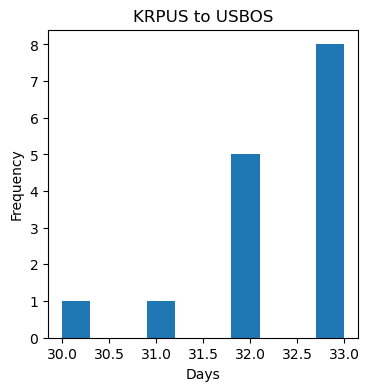

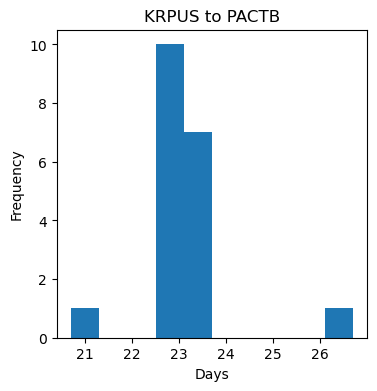

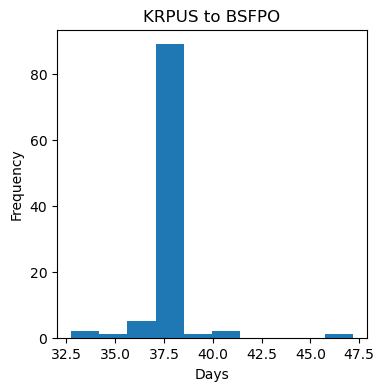

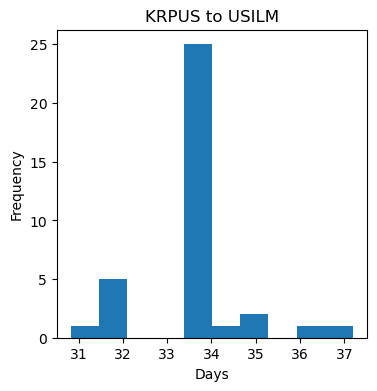

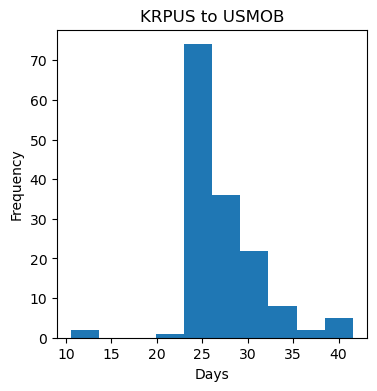

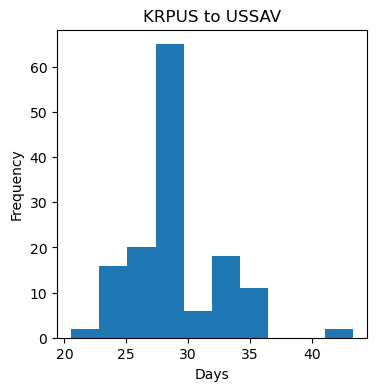

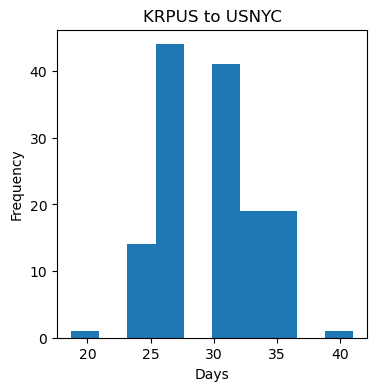

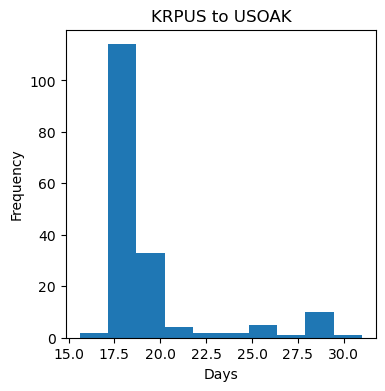

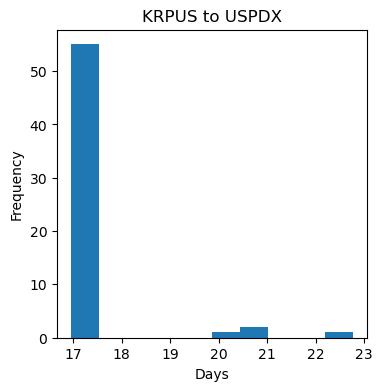

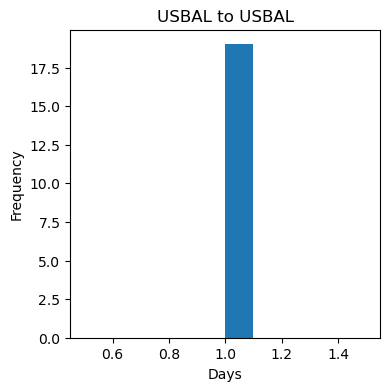

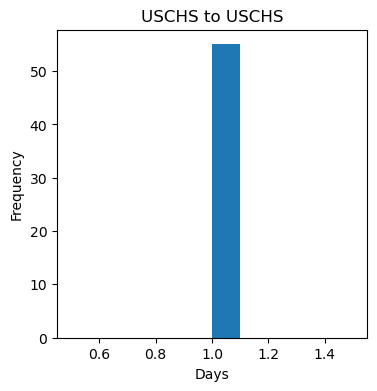

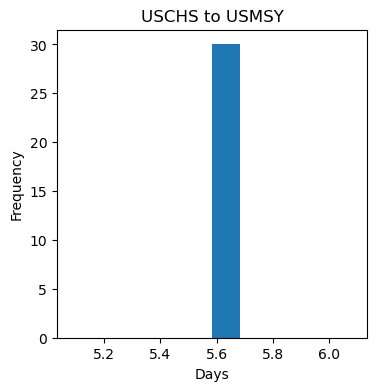

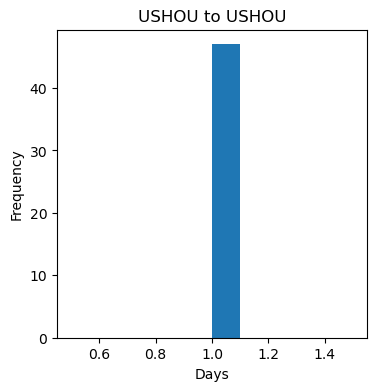

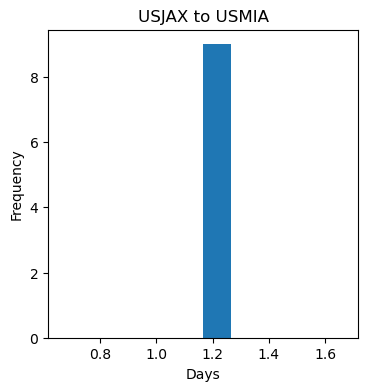

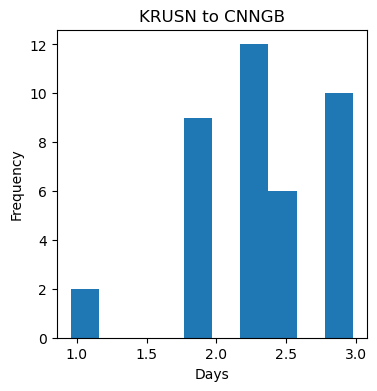

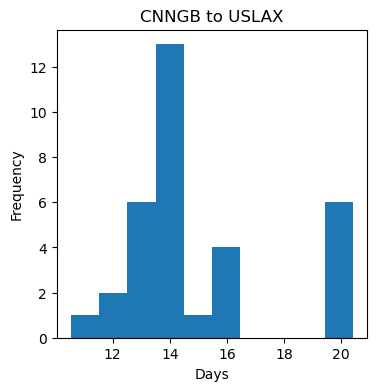

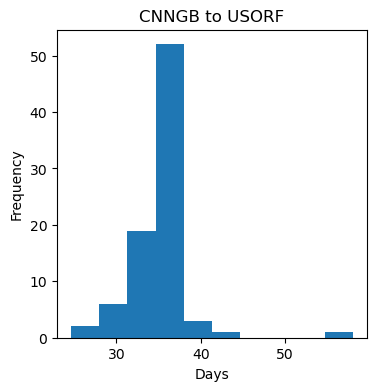

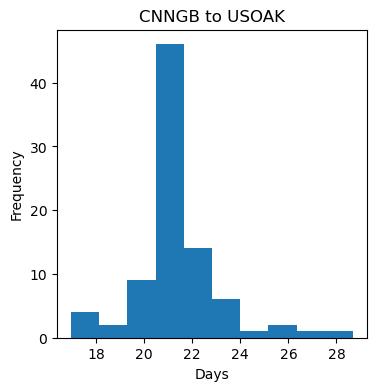

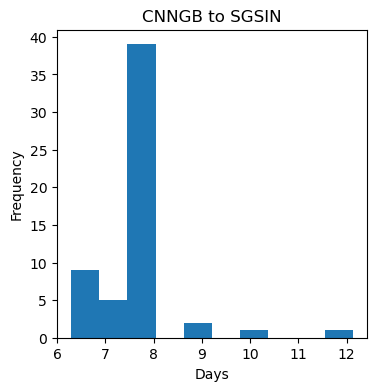

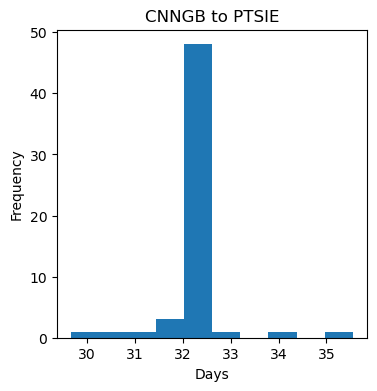

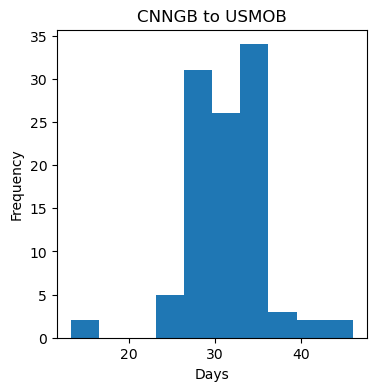

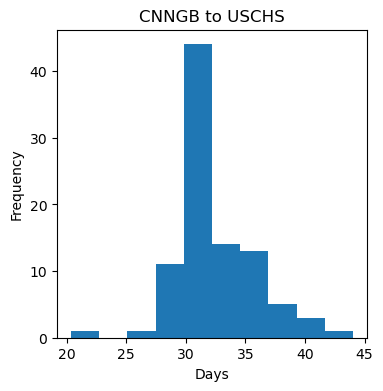

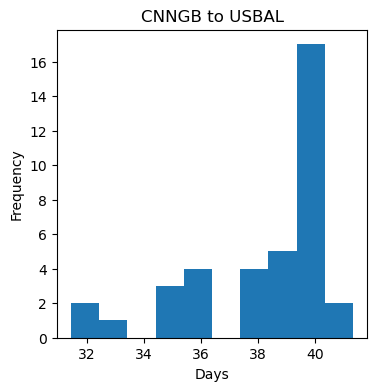

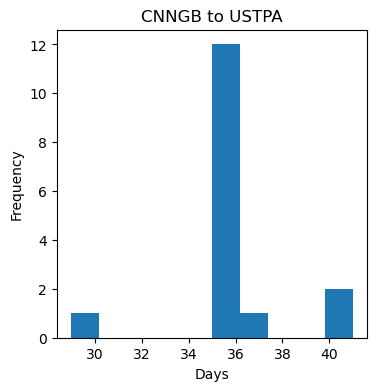

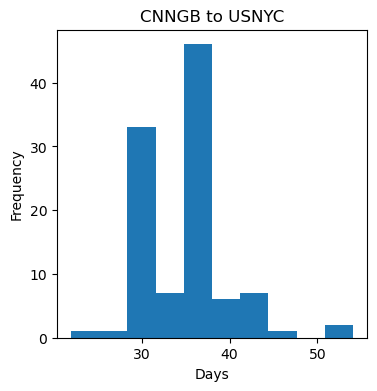

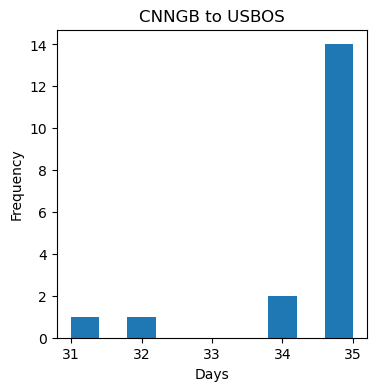

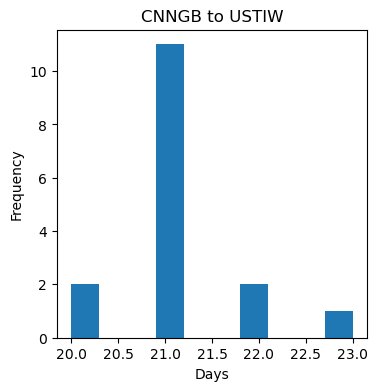

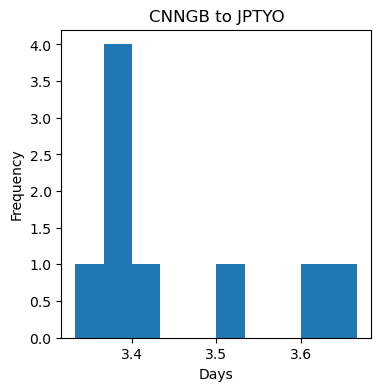

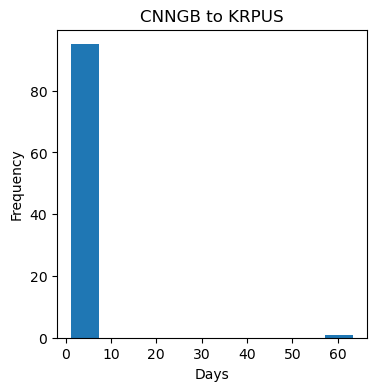

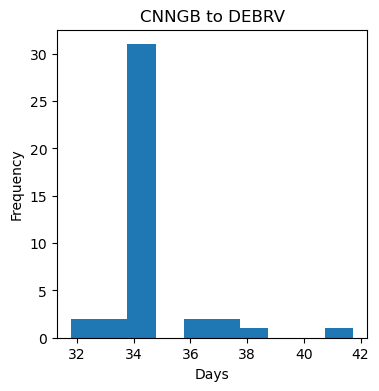

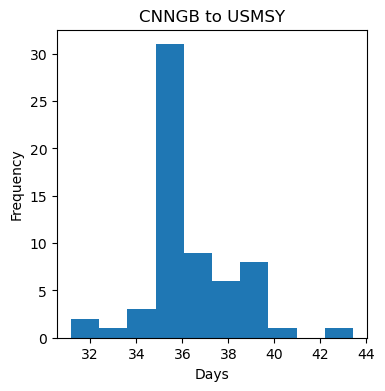

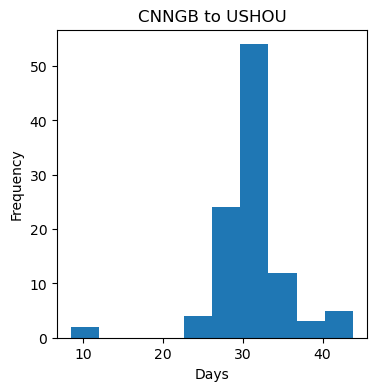

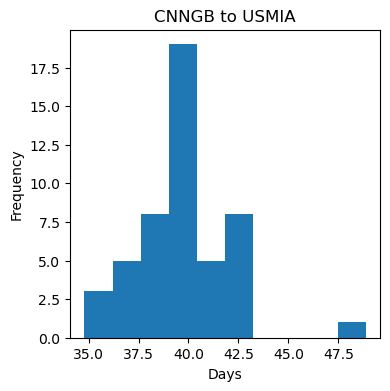

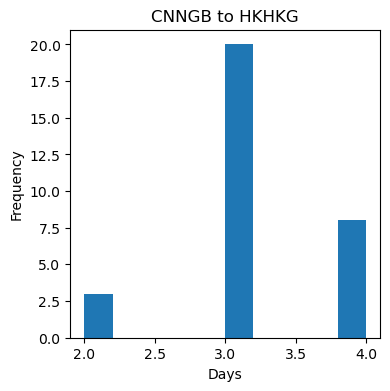

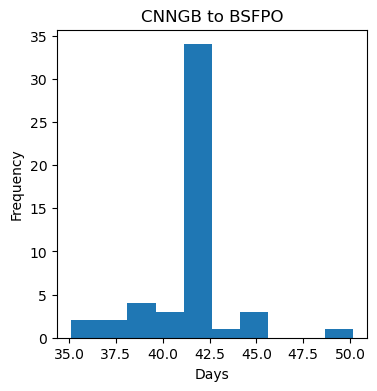

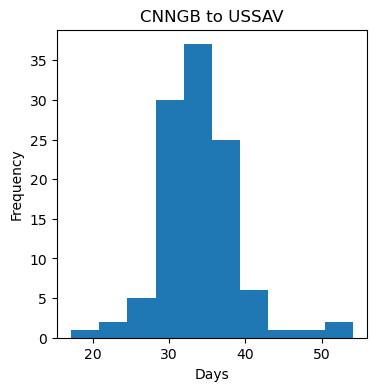

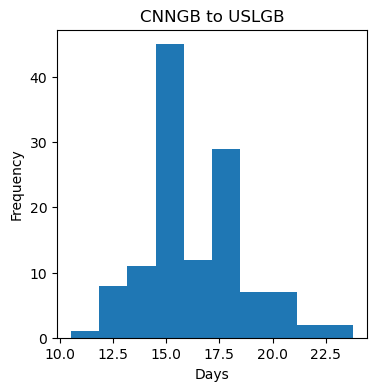

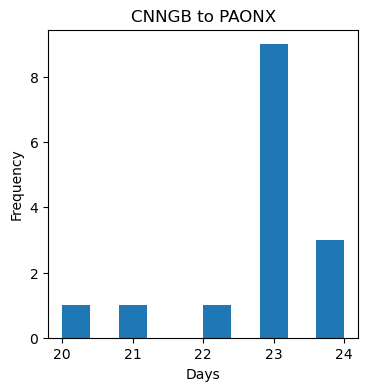

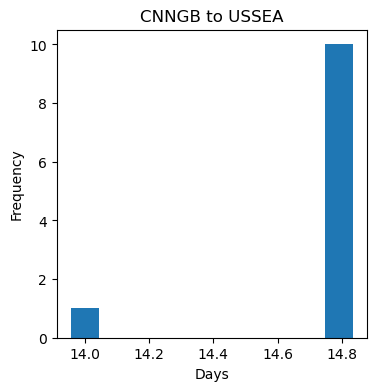

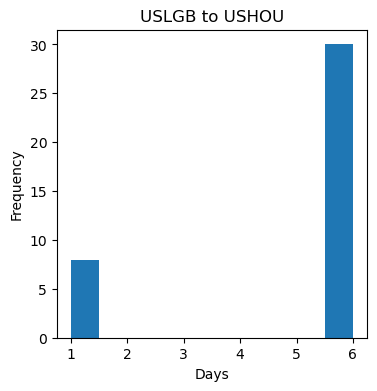

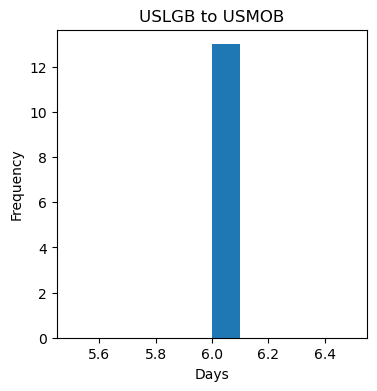

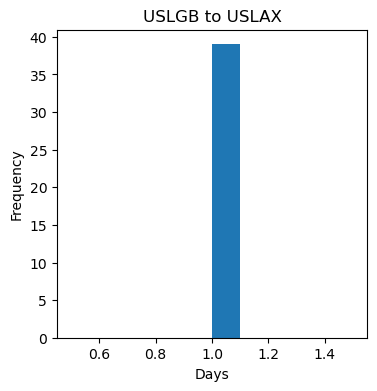

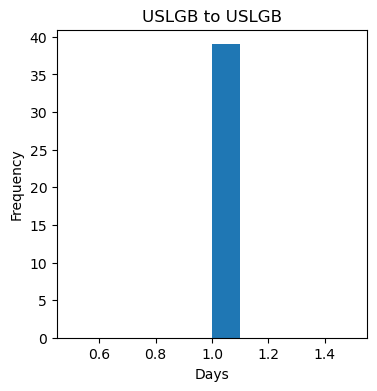

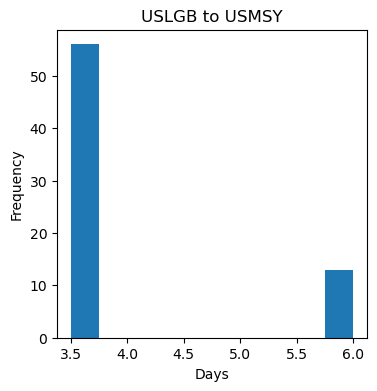

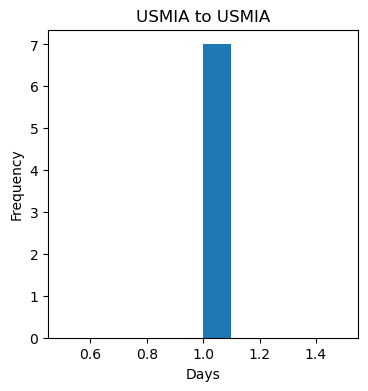

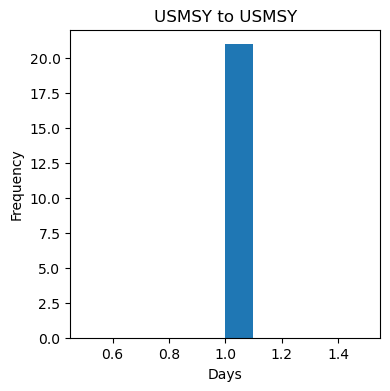

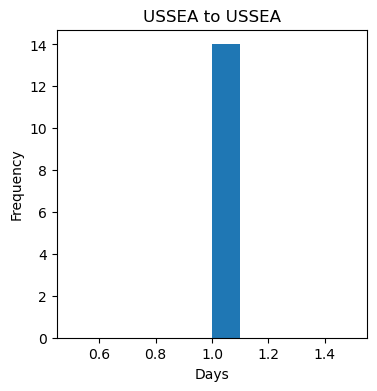

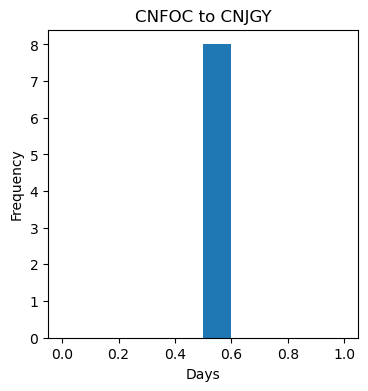

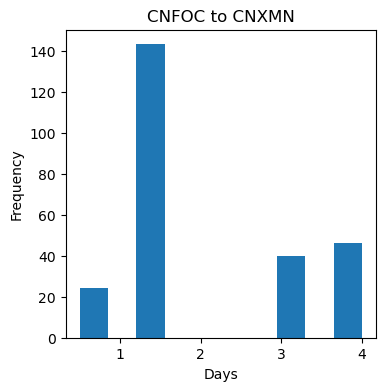

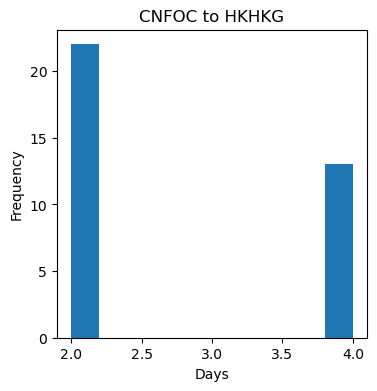

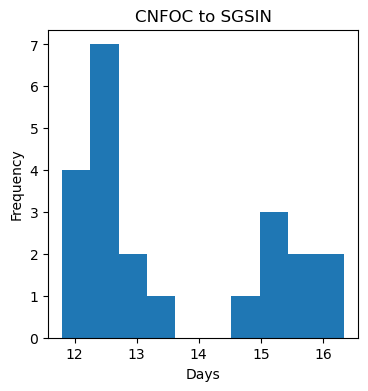

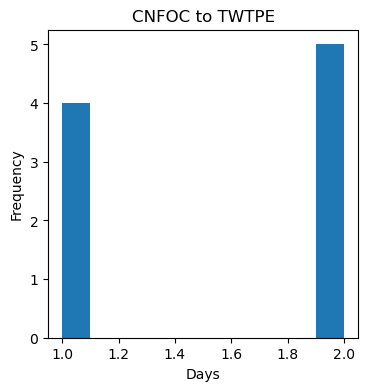

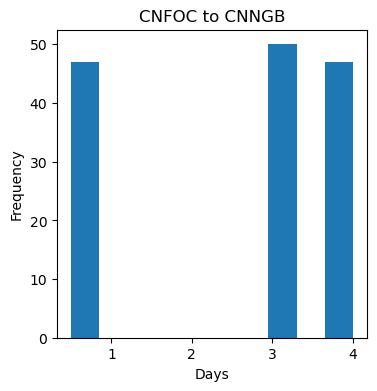

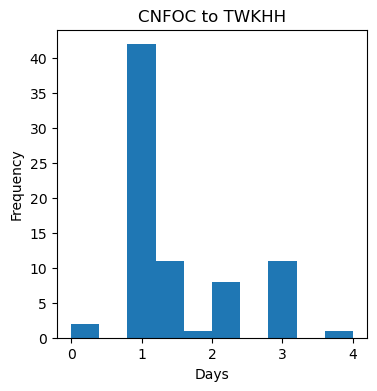

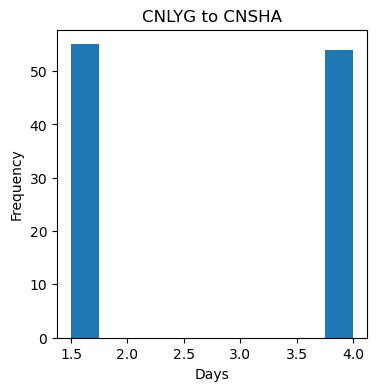

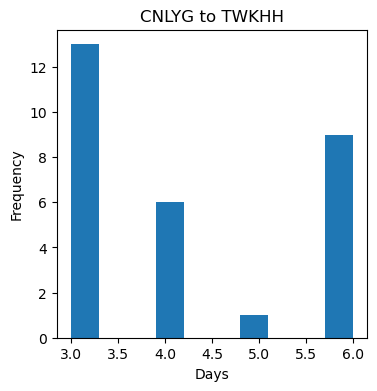

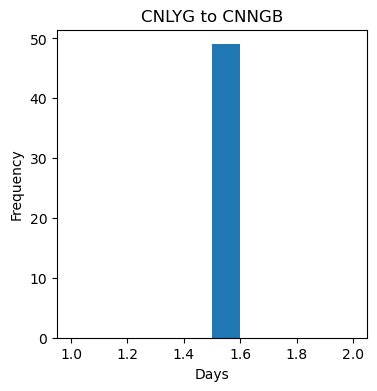

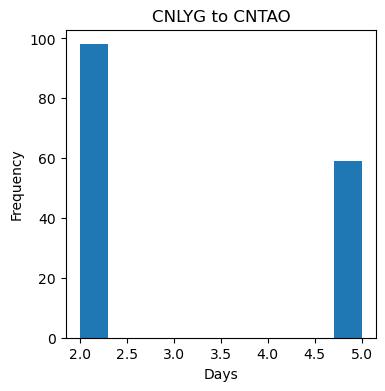

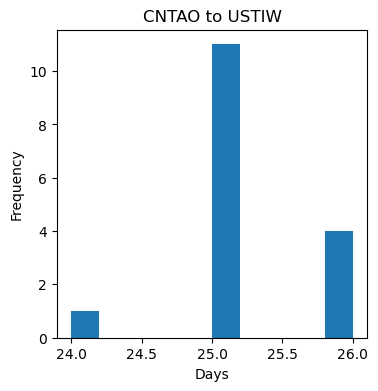

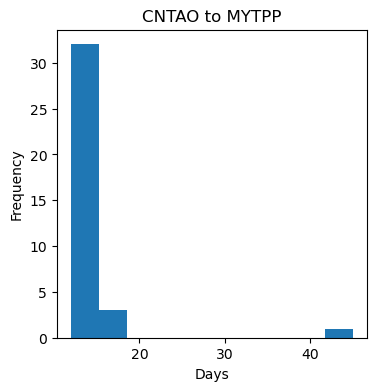

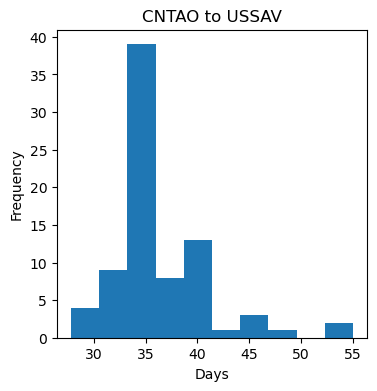

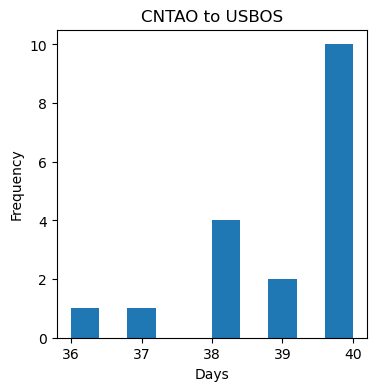

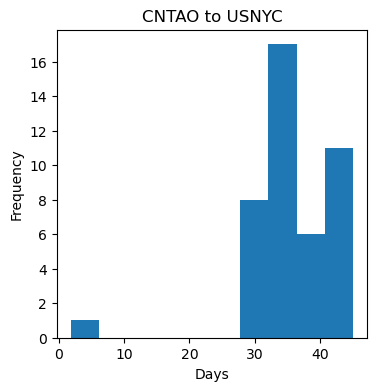

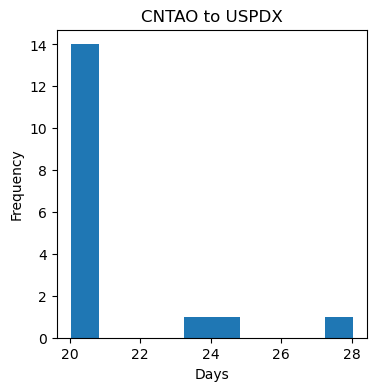

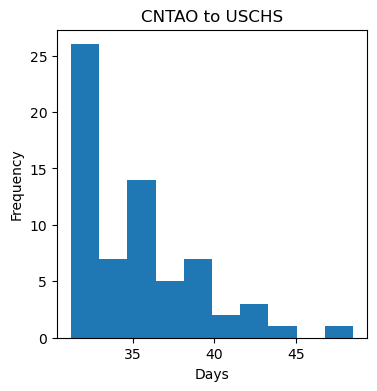

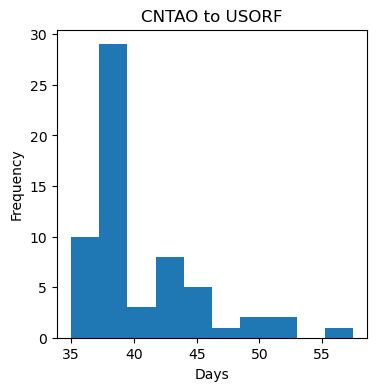

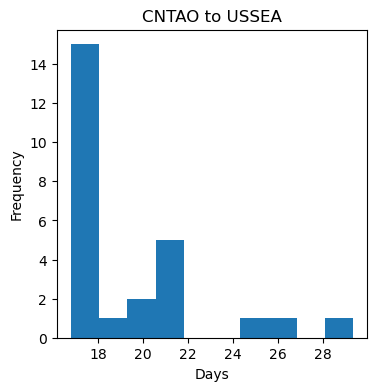

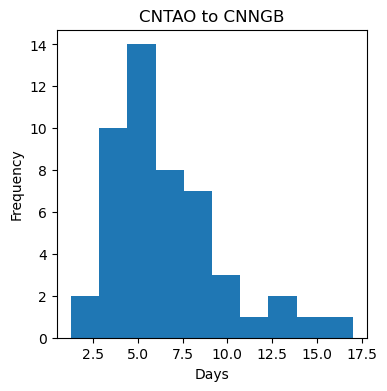

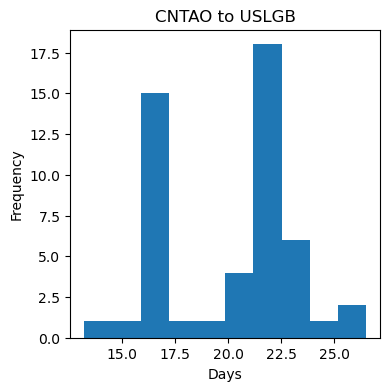

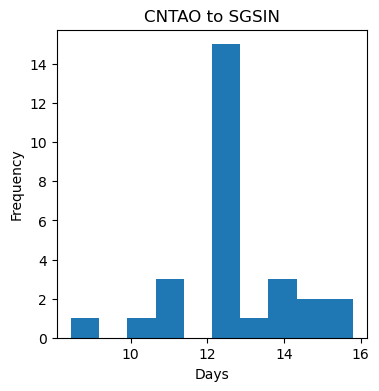

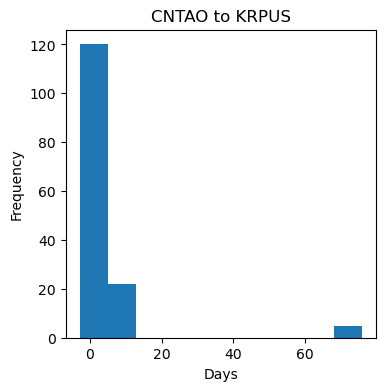

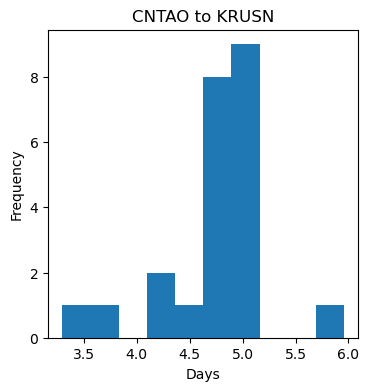

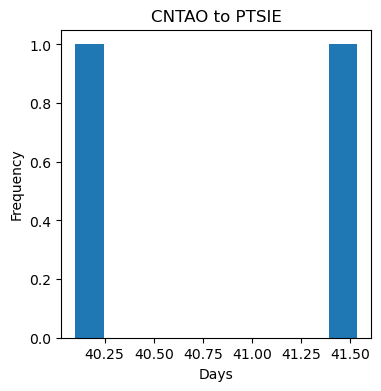

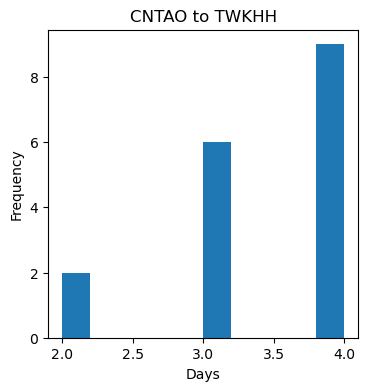

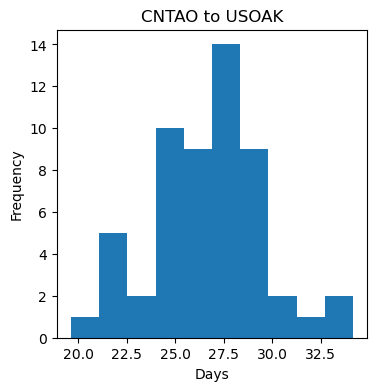

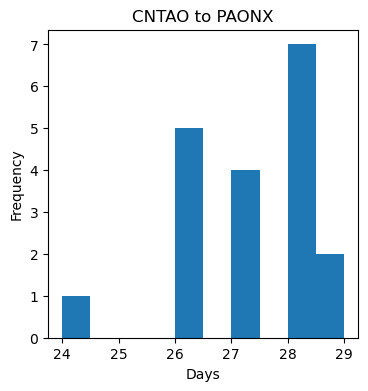

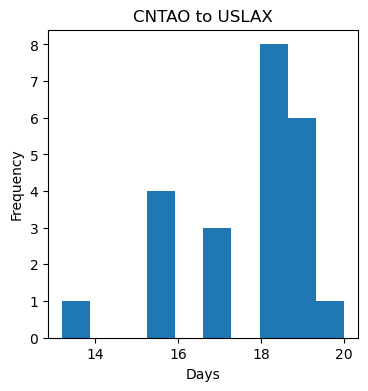

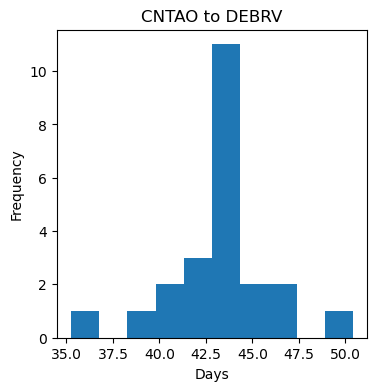

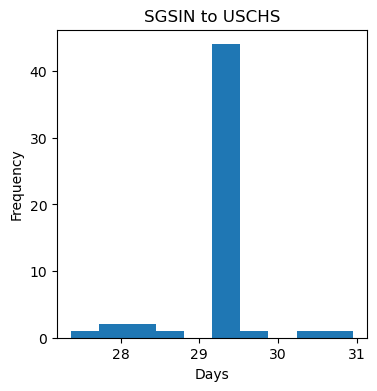

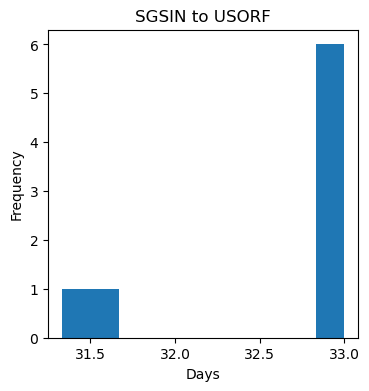

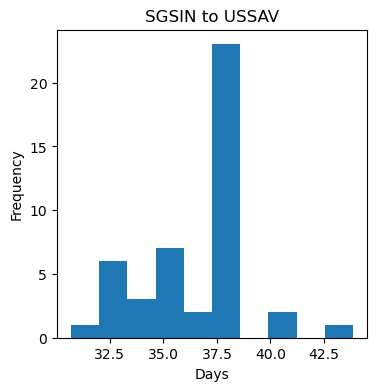

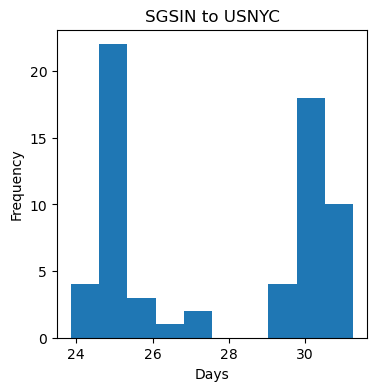

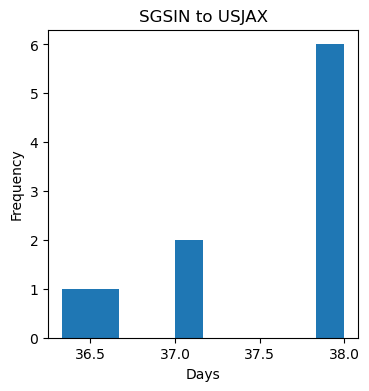

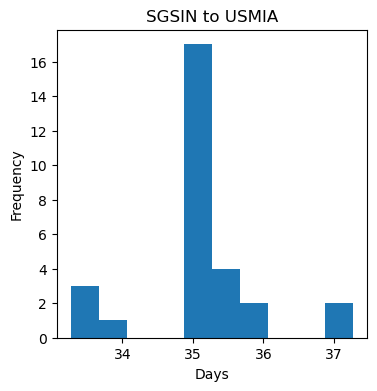

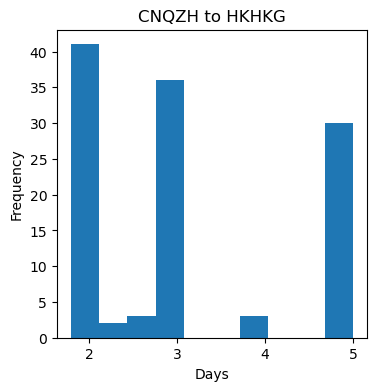

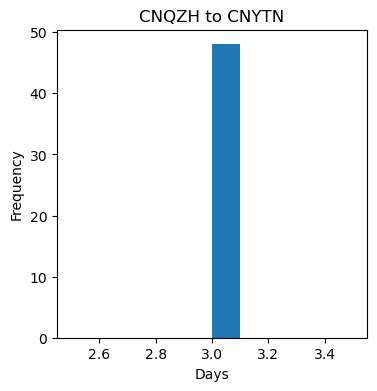

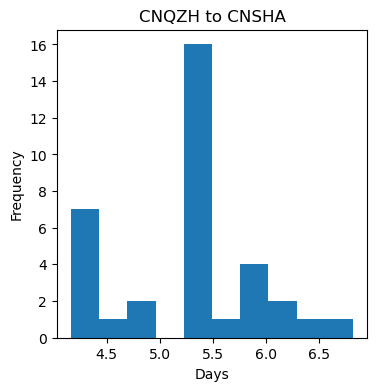

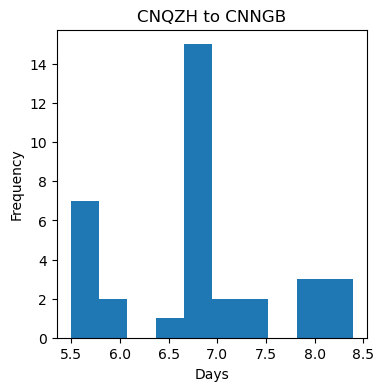

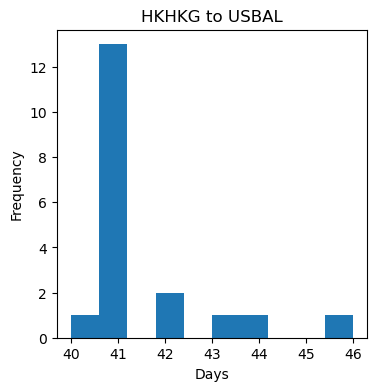

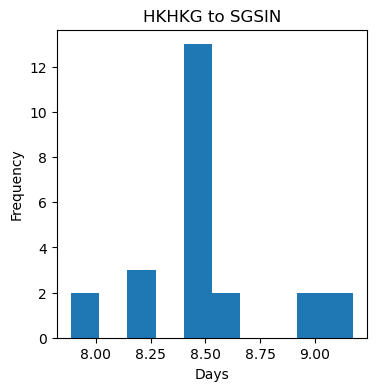

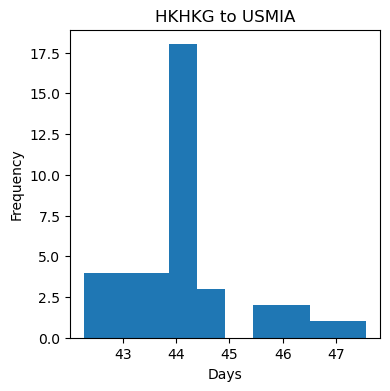

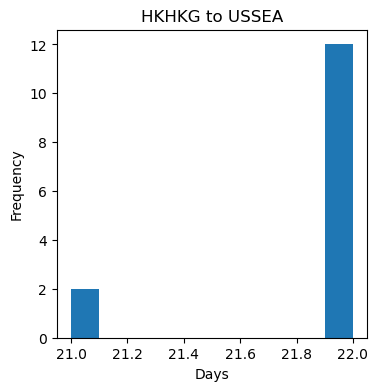

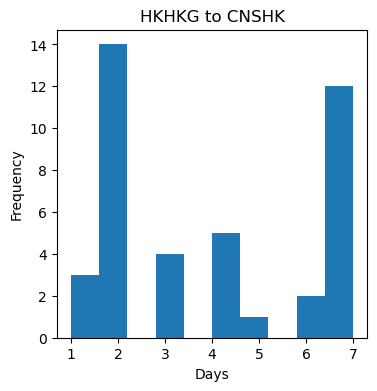

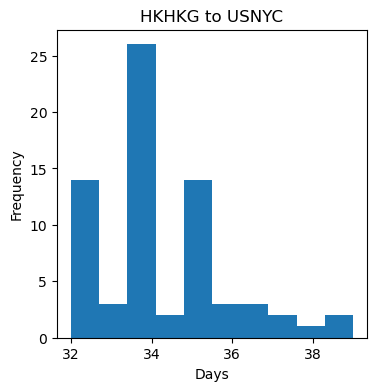

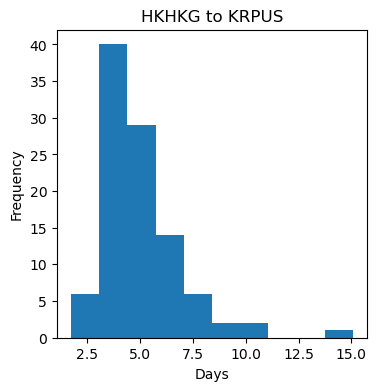

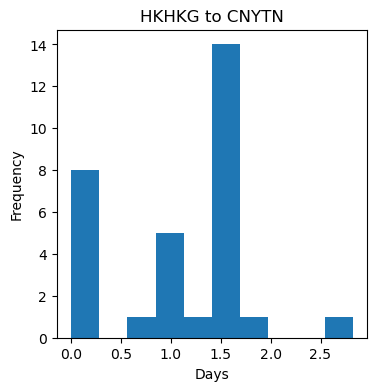

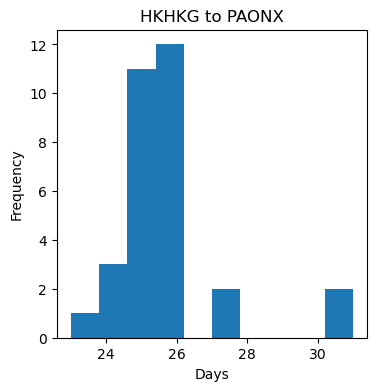

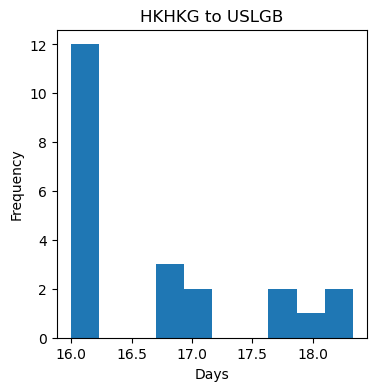

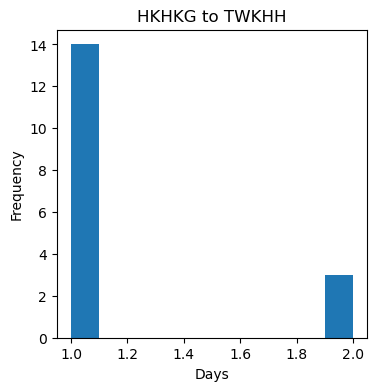

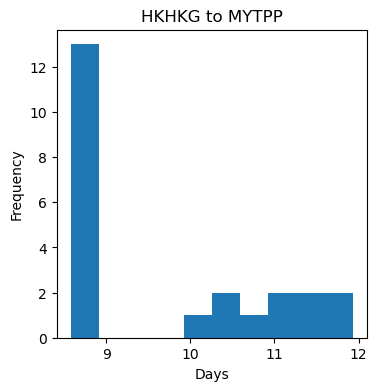

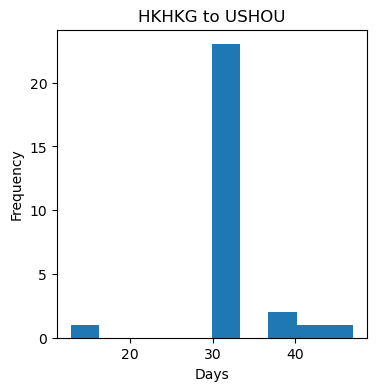

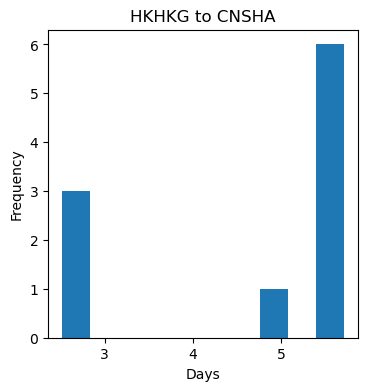

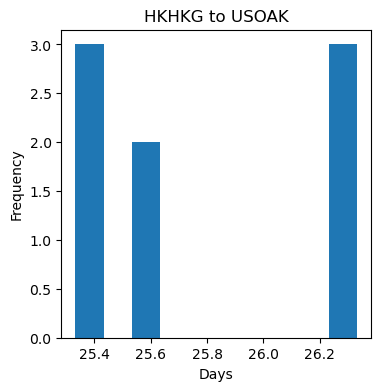

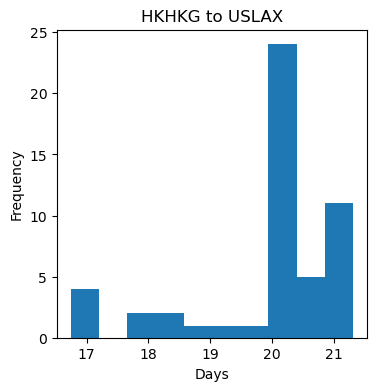

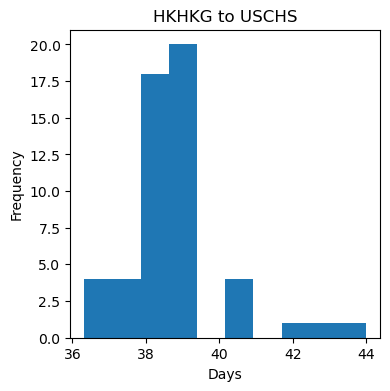

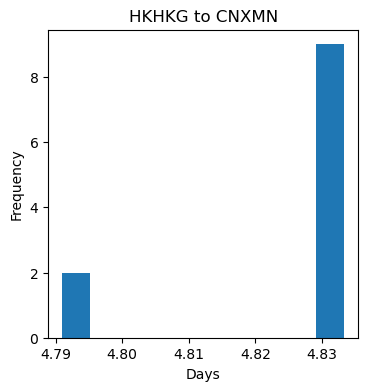

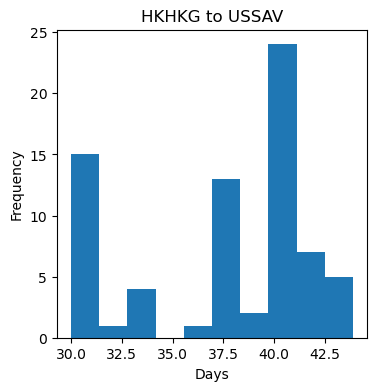

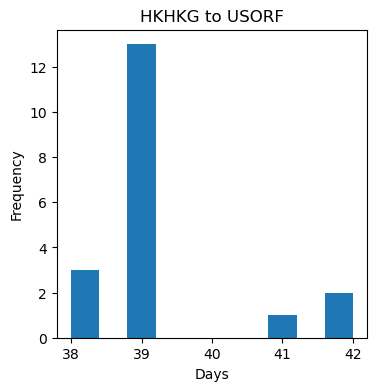

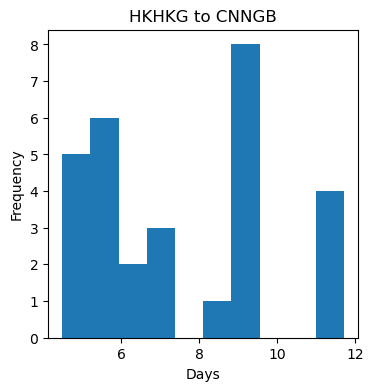

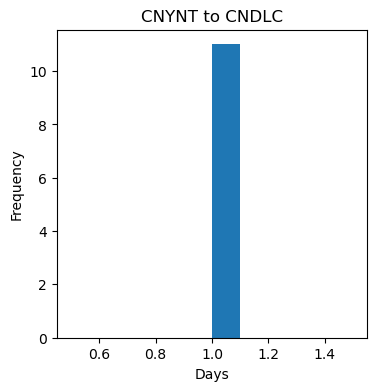

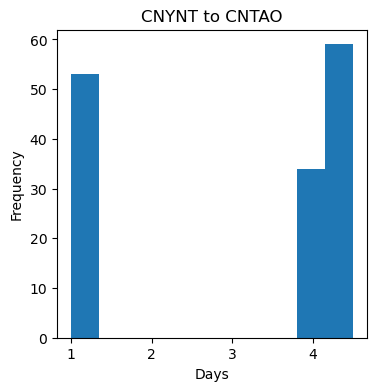

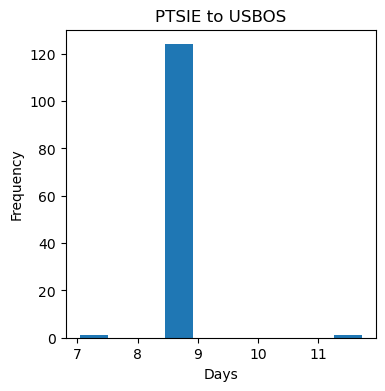

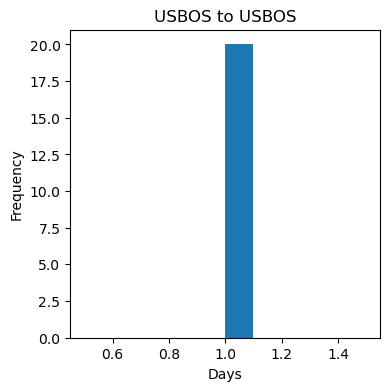

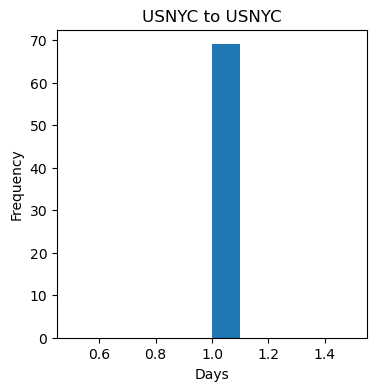

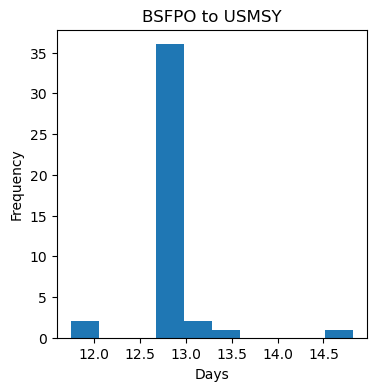

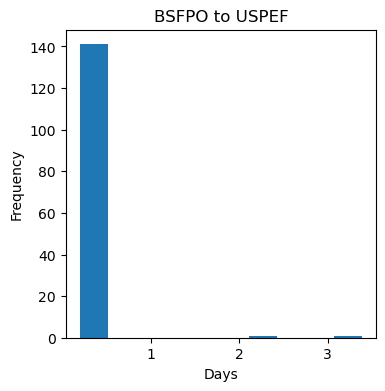

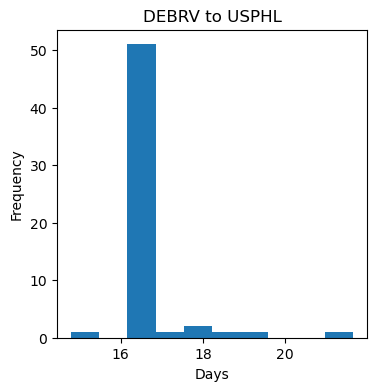

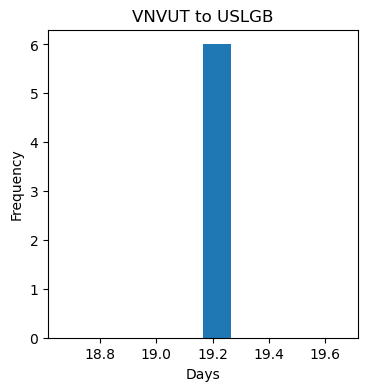

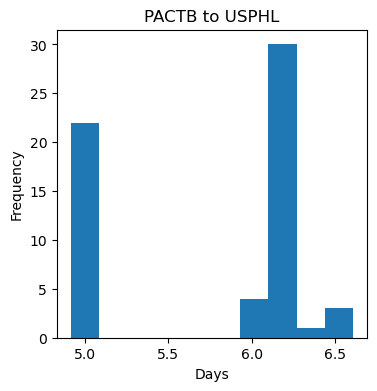

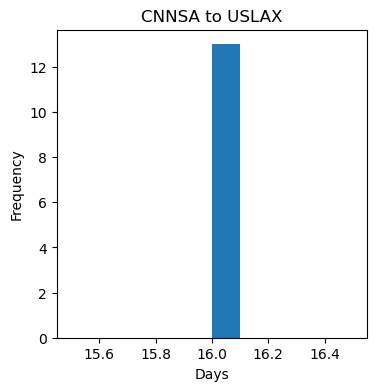

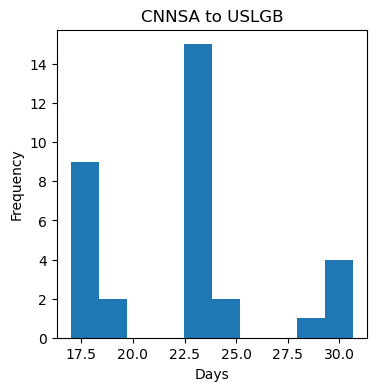

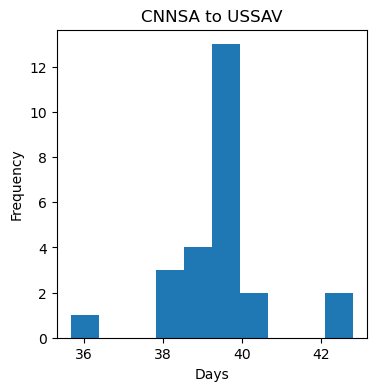

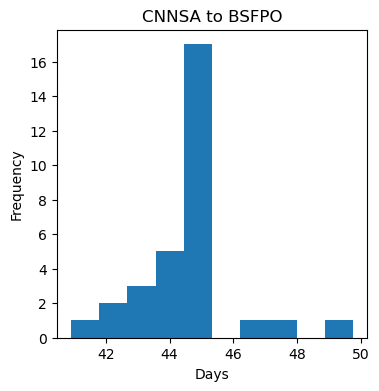

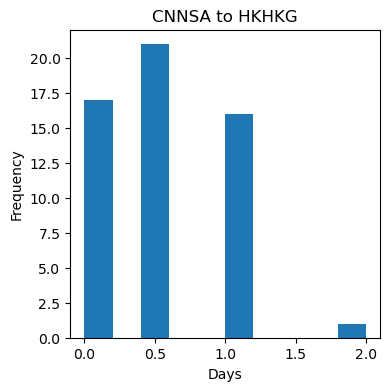

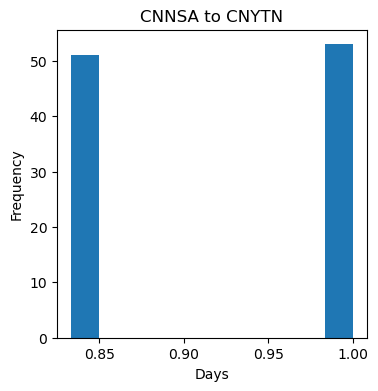

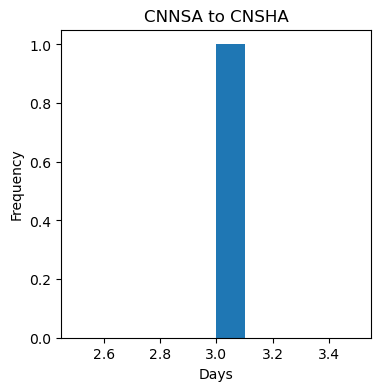

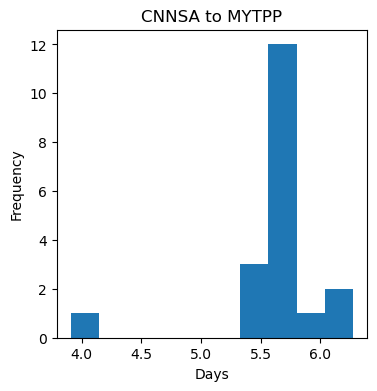

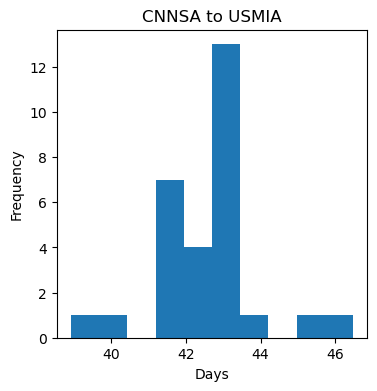

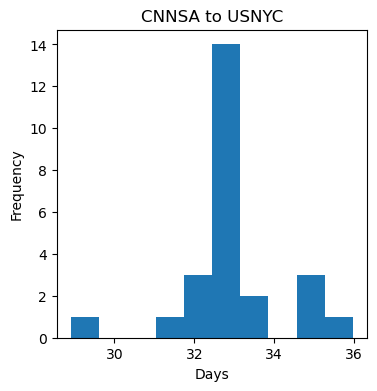

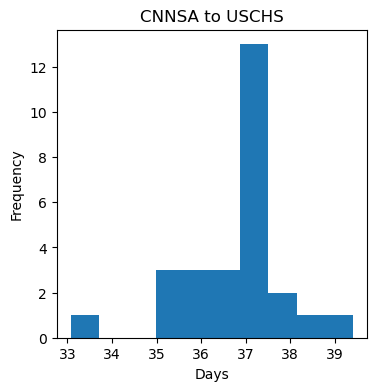

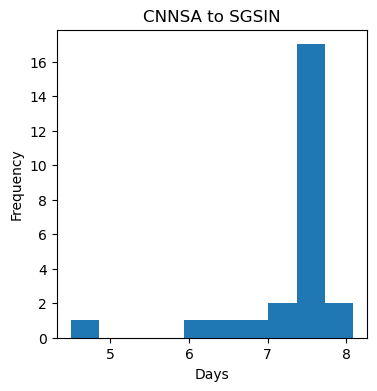

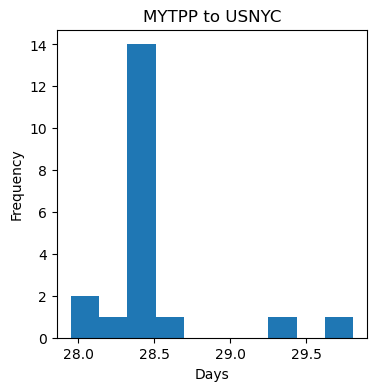

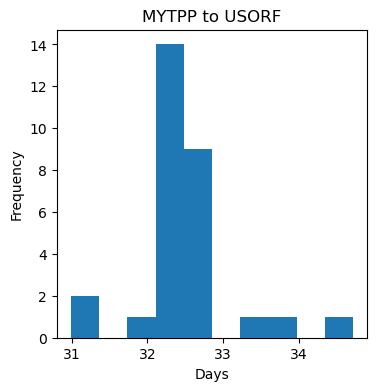

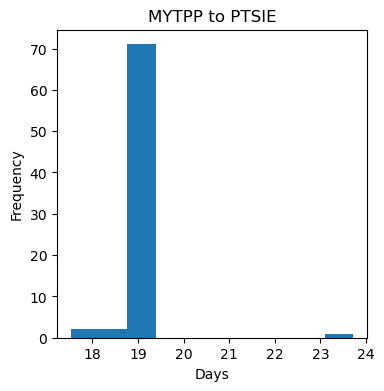

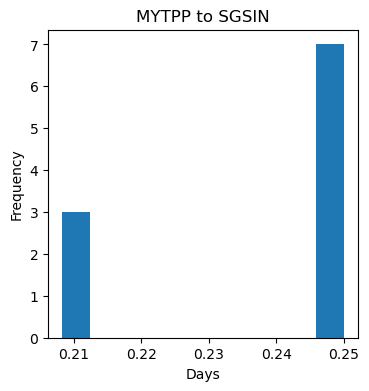

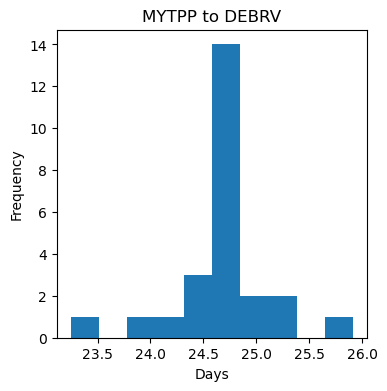

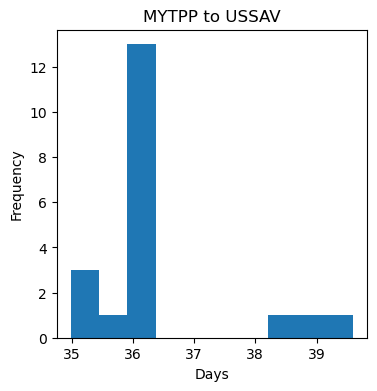

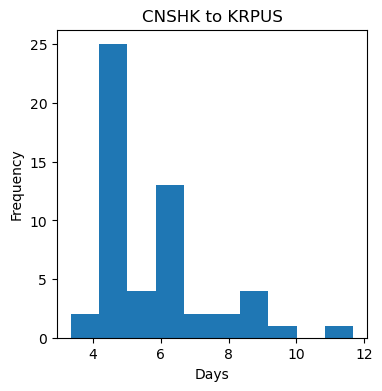

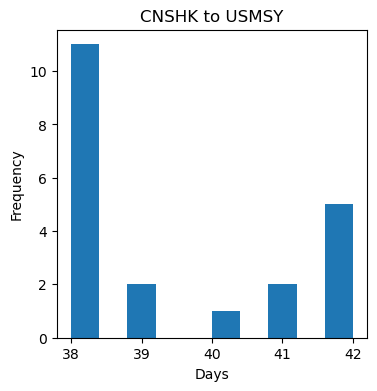

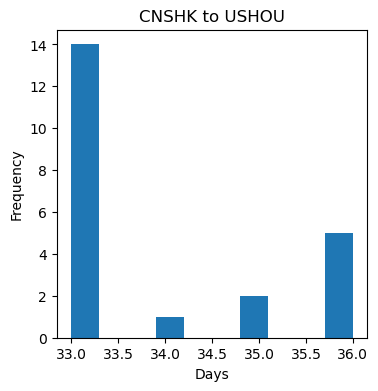

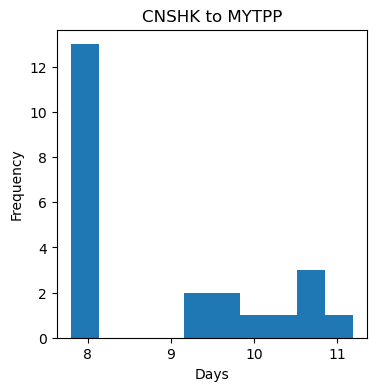

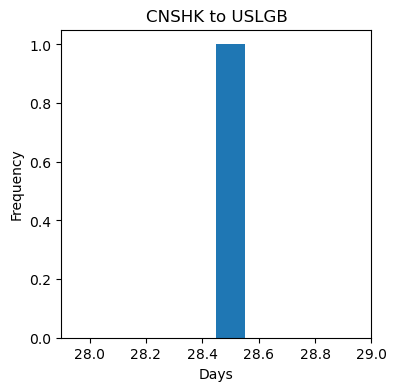

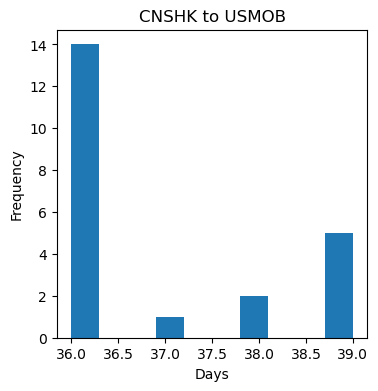

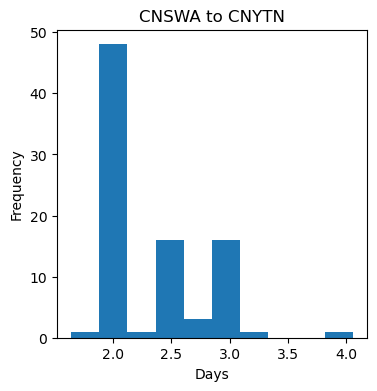

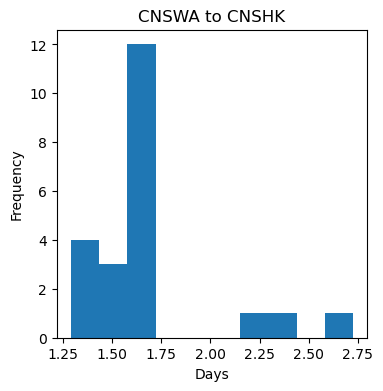

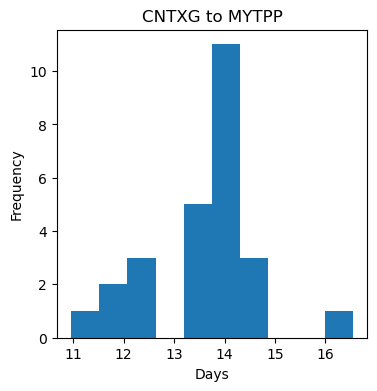

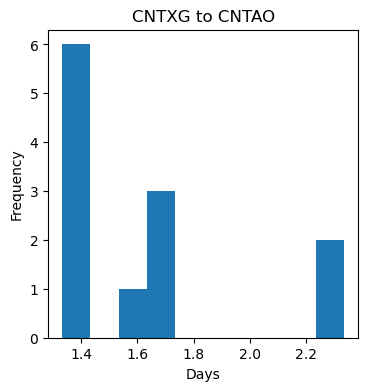

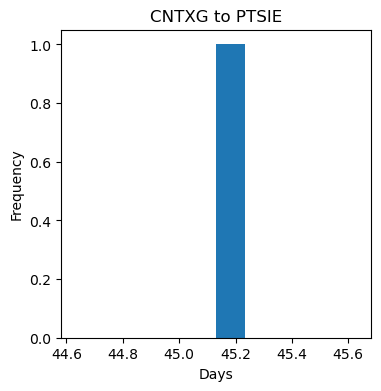

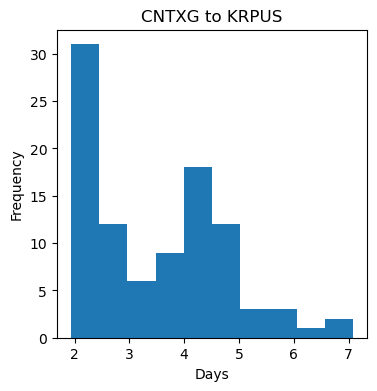

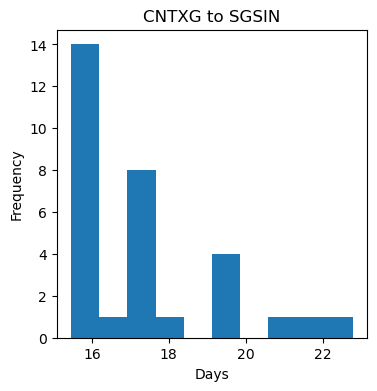

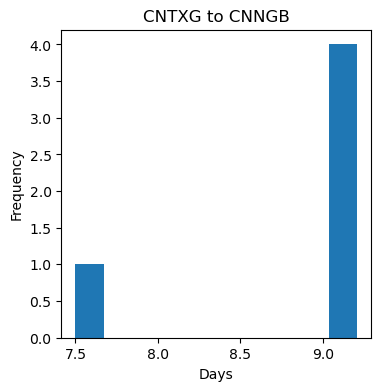

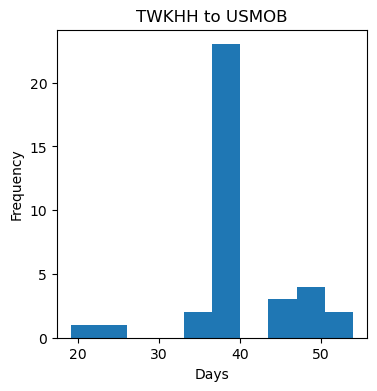

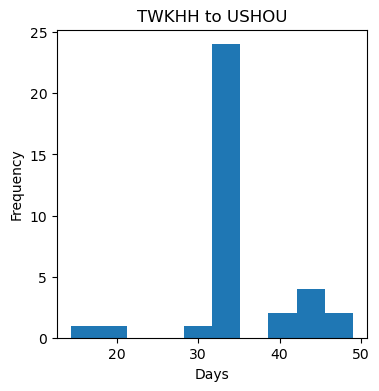

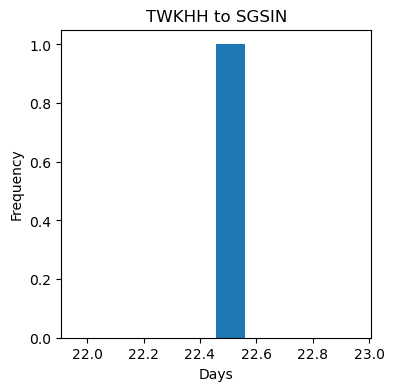

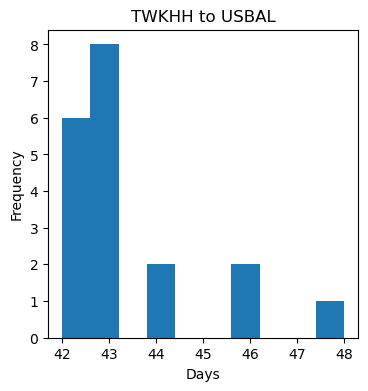

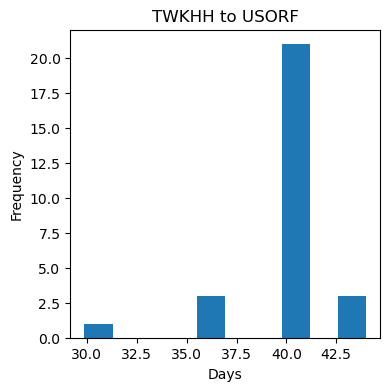

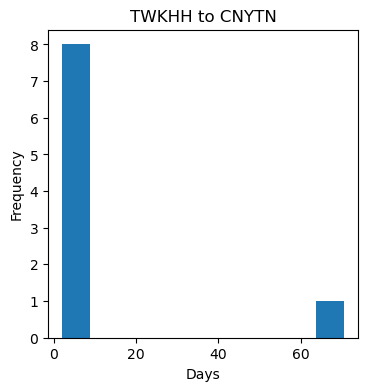

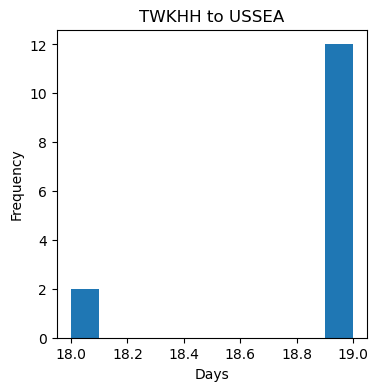

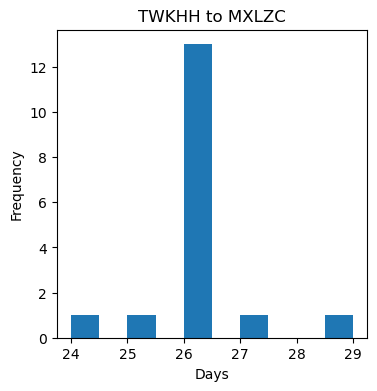

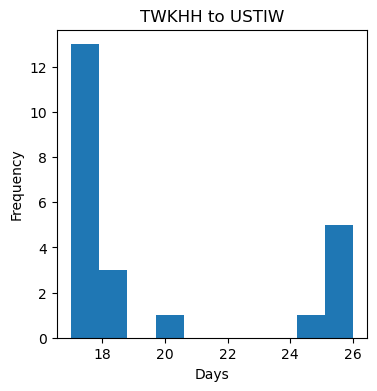

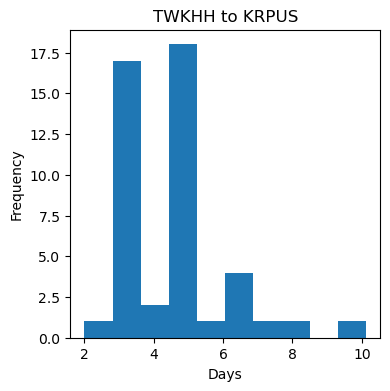

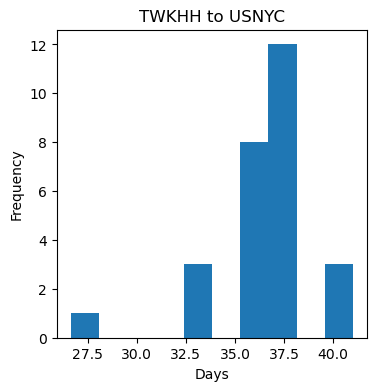

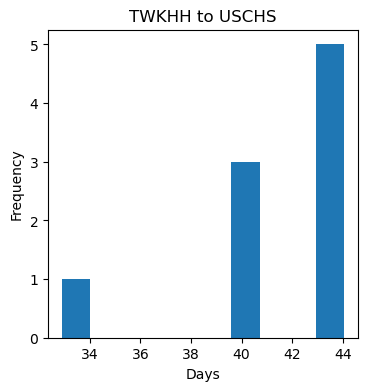

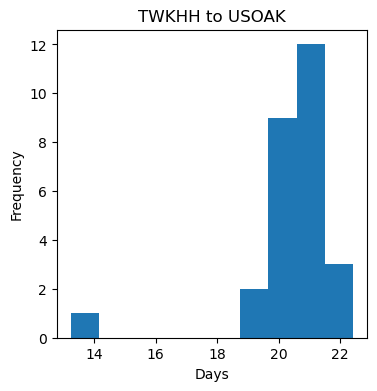

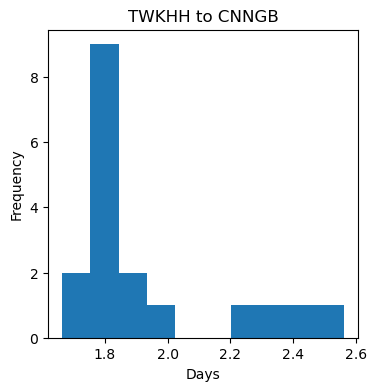

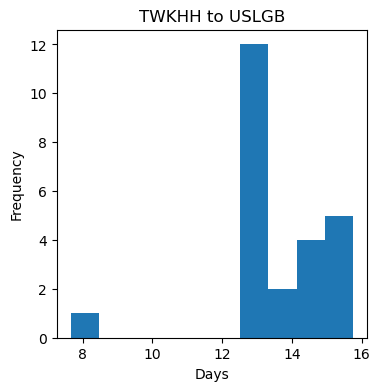

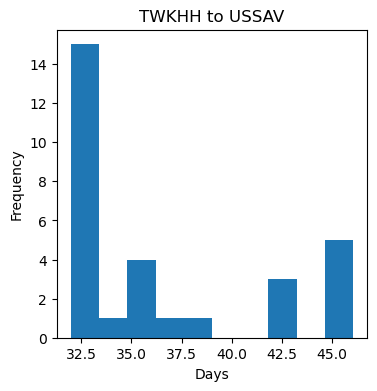

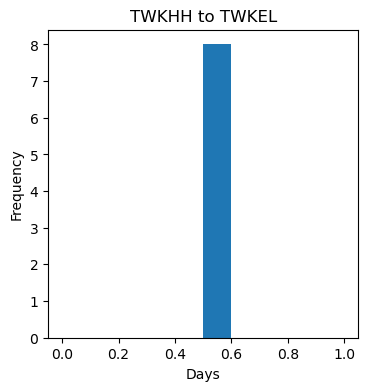

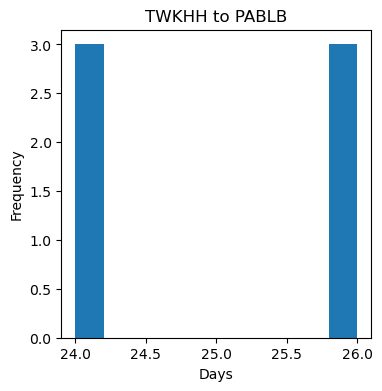

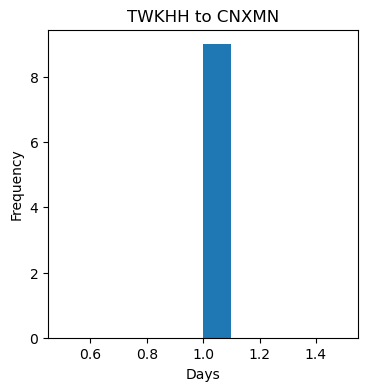

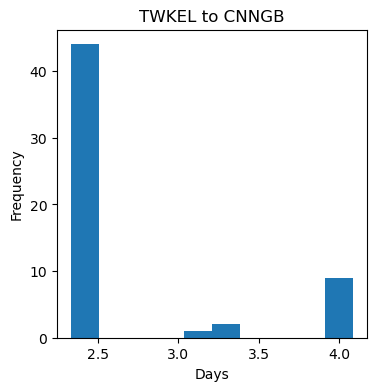

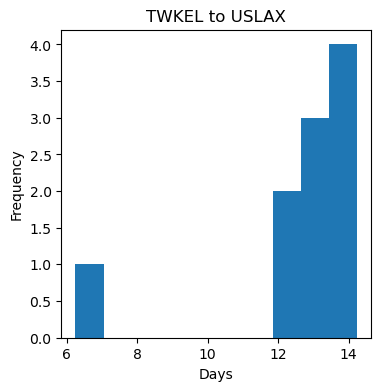

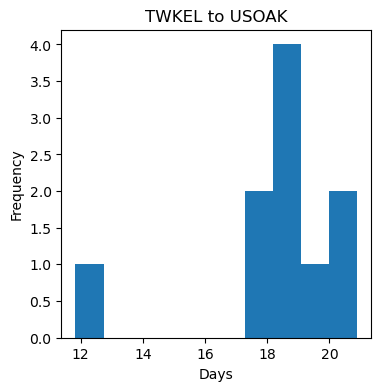

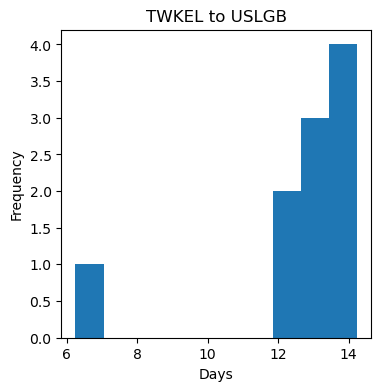

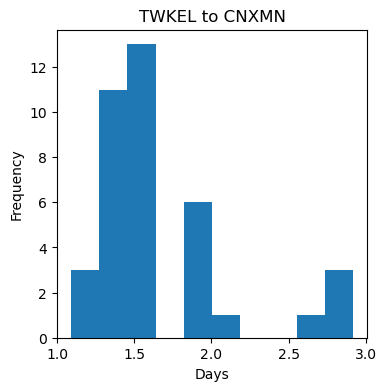

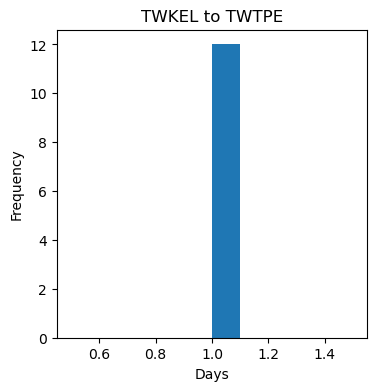

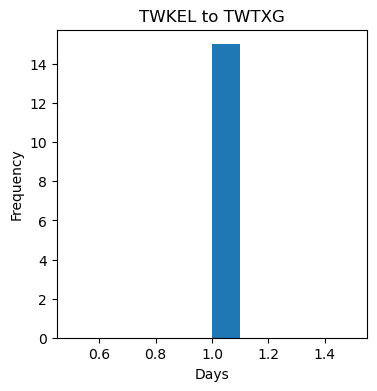

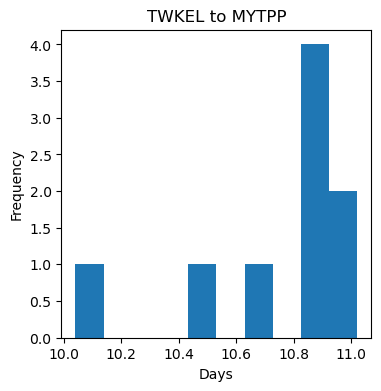

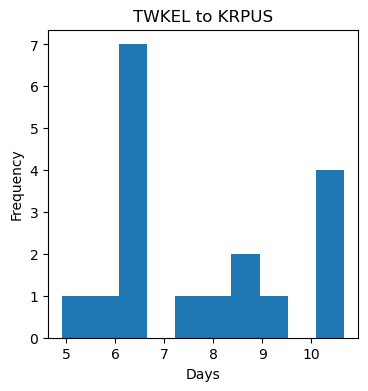

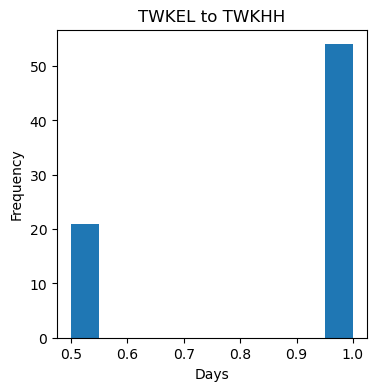

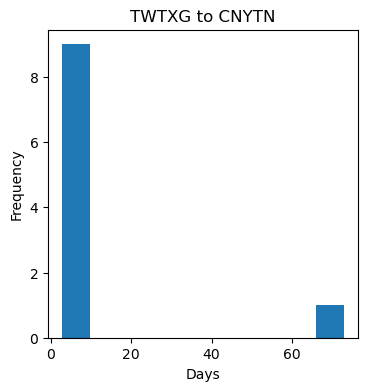

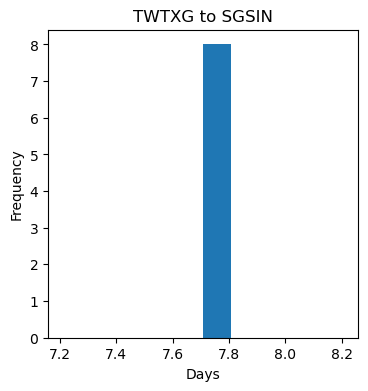

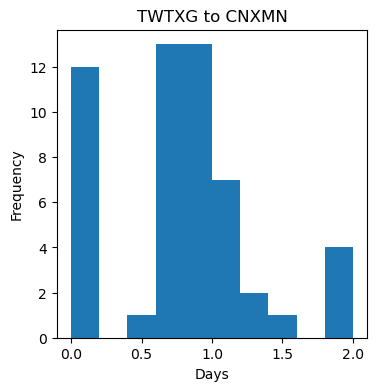

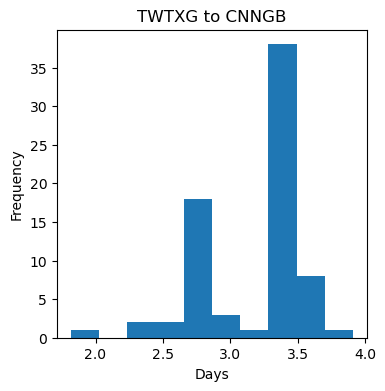

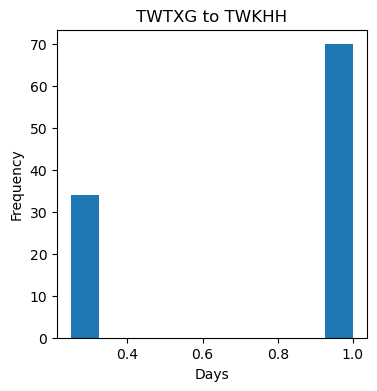

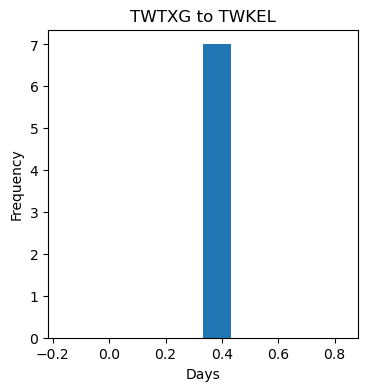

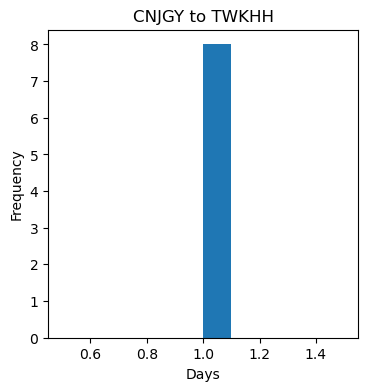

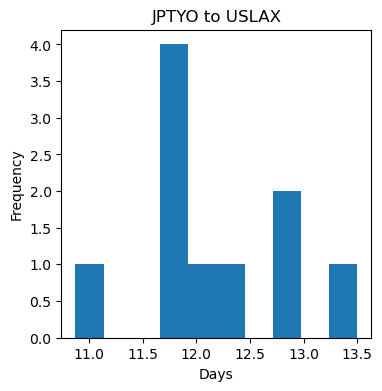

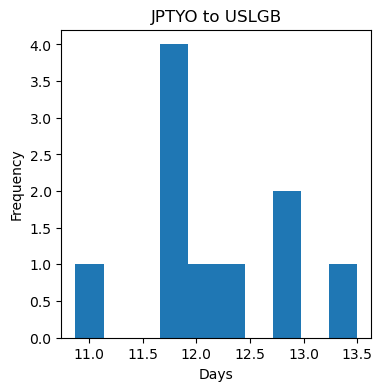

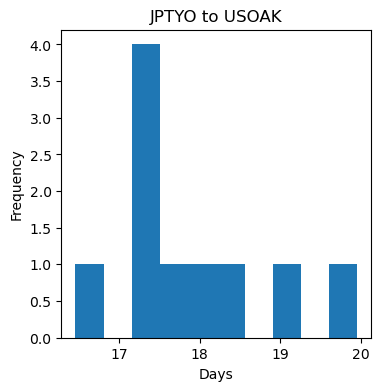

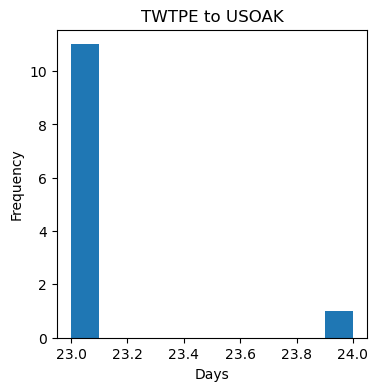

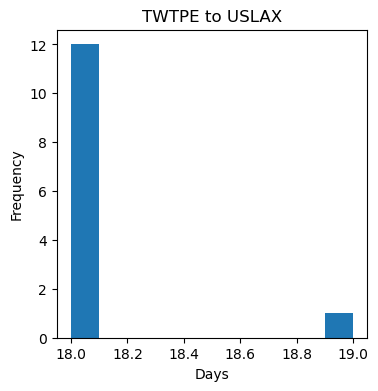

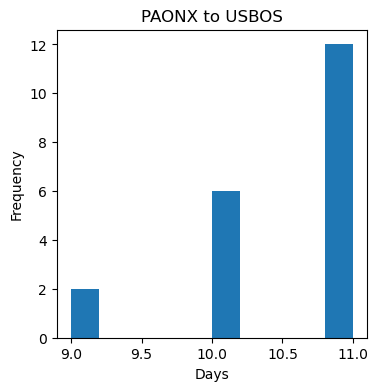

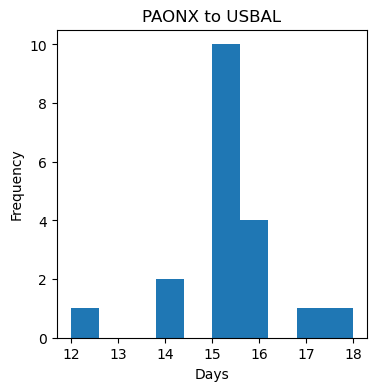

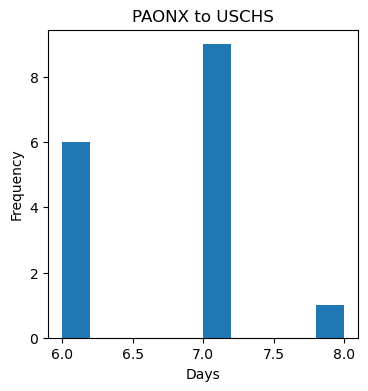

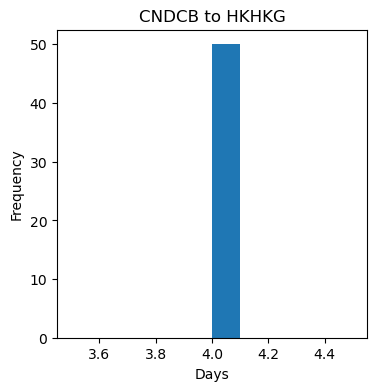

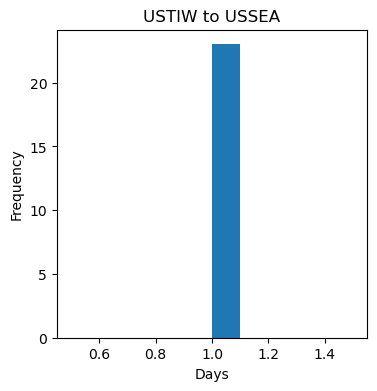

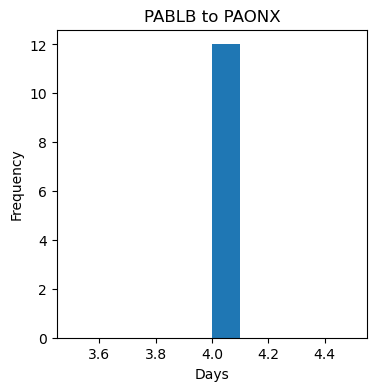

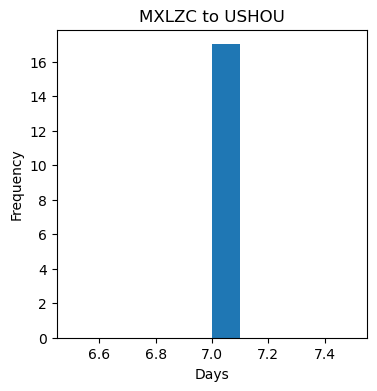

In [8]:
for edge in G.edges(data=True):
    plt.figure(figsize=(4,4))
    plt.title(edge[0] + " to " + edge[1])
    plt.ylabel("Frequency")
    plt.xlabel("Days")
    #plt.hist([e/60/24 for e in edge[2]["time_minutes"]])
    plt.hist([k[2]/60/24 for k, v in edge[2]["frequency"].items()])

# Plot with Plotly

In [24]:
import plotly.graph_objects as go

In [25]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = (G.nodes[edge[0]]['longitude'], G.nodes[edge[0]]['latitude'])
    x1, y1 = (G.nodes[edge[1]]['longitude'], G.nodes[edge[1]]['latitude'])
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = (G.nodes[node]['longitude'], G.nodes[node]['latitude'])
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [26]:
node_adjacencies = []
node_text = []
for n, attributes in G.nodes(data=True):
    node_text.append(("Port UN Code: "+ str(n) + "\r\n Location: " + "(" + str(attributes["longitude"]) + "," + str(attributes["latitude"]) + ")"))

for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [27]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>International shipping routes',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Calculate Betweenness with igraph

In [9]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [10]:
ig_G = ig.Graph.from_networkx(G)

In [11]:
def plot_betweenness(g, vertex_betweenness, edge_betweenness, ax, cax1, cax2):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "blueviolet"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]
    g.vs["size"]  = ig.rescale(vertex_betweenness, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))
    
    # Set coordinates
    lat = g.vs.get_attribute_values('latitude')
    lon = g.vs.get_attribute_values("longitude")
    
    coords = []
    for la,lo in zip(lat, lon):
        c = (lo, la)
        coords.append(c)
        
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords
        vertex_frame_width=0.2,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')

Calculate betweenness without weights

In [12]:
#Unweighted shortest path now! 
vertex_betweenness1 = ig_G.betweenness()
edge_betweenness1 = ig_G.edge_betweenness()

In [13]:
centrality_df = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness1, edge_betweenness1, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [14]:
centrality_df

port  betweenness  edge_betweenness  in_degree  out_degree  \
0   CNSHA    48.630952          1.500000          5          27   
1   USOAK     0.000000          1.833333         13           1   
2   USMOB     0.000000          1.500000         11           1   
3   USSAV     7.509524          1.783333         12           4   
4   CNXMN    89.445238          4.000000          5          26   
5   USLAX    10.740079          2.583333         14           6   
6   CNYTN    64.864286          1.783333          8          25   
7   USORF     2.311111          3.166667         11           2   
8   CNDLC    16.816667          3.783333          1           7   
9   KRPUS    79.183333          3.083333         11          22   
10  USBAL     0.000000          3.500000         10           1   
11  USCHS     3.884524          1.700000         12           2   
12  USHOU     0.000000          1.916667         12           1   
13  USJAX     0.166667          1.833333          6           1   
14  KRUSN     0.000000          1.500000          2           1   
15  CNNGB   134.123810          3.154762         11          24   
16  USLGB     9.990079          2.400000         15           5   
17  USMIA     7.823810          2.559524         10           2   
18  USMSY     0.000000          5.619048         10           1   
19  USSEA     0.000000          1.500000         10           1   
20  USTPA     2.471429          2.171429          5           1   
21  CNFOC    24.166667          1.500000          1           8   
22  CNLYG     0.000000         30.000000          0           4   
23  CNTAO    53.716667          2.754762          4          20   
24  SGSIN    11.888095          2.254762         13           6   
25  CNQZH     0.000000          1.750000          0           4   
26  HKHKG   182.896429          1.500000         10          22   
27  CNYNT     0.000000          0.000000          0           2   
28  PTSIE     2.033333          0.000000          7           1   
29  USBOS     0.000000          3.941667          7           1   
30  USILM     0.000000          3.683333          4           0   
31  USNYC     0.000000          0.000000         12           1   
32  USPDX     0.000000          3.884524          4           0   
33  BSFPO     2.642857          1.783333          5           2   
34  USPEF     0.000000          1.650000          4           0   
35  DEBRV    13.157143          1.333333          5           1   
36  USPHL     0.000000          3.666667          2           0   
37  VNVUT     0.000000          1.533333          1           1   
38  PACTB     9.842857          6.102381          4           1   
39  CNNSA     0.000000          5.166667          0          12   
40  MYTPP    14.385714          1.566667          9           6   
41  CNSHK     2.826190          1.900000          2           6   
42  CNSWA     0.000000          6.166667          0           4   
43  CNTXG     0.000000          4.166667          0           7   
44  TWKHH   150.788095          1.533333          9          21   
45  TWKEL    32.566667          3.333333          2          10   
46  TWTXG     1.533333          3.704762          1           7   
47  CNJGY     0.000000          1.983333          1           1   
48  JPTYO     0.000000         20.000000          1           3   
49  TWTPE     0.333333          3.538095          2           2   
50  PAONX     6.261111          1.566667          9           3   
51  CNDCB     0.000000         43.166667          0           1   
52  USTIW     0.000000          1.366667          5           1   
53  PABLB     0.000000          1.566667          2           1   
54  MXLZC     0.000000          7.000000          1           1   

    sum_of_degrees  closeness  
0               32   0.675000  
1               14   0.556701  
2               12   0.540000  
3               16   0.562500  
4               31   0.658537  
5               20   0.586957  
6               33   0.70129

vertices: 0.0 - 182.8964285714286
edges: 0.0 - 52.75238095238095


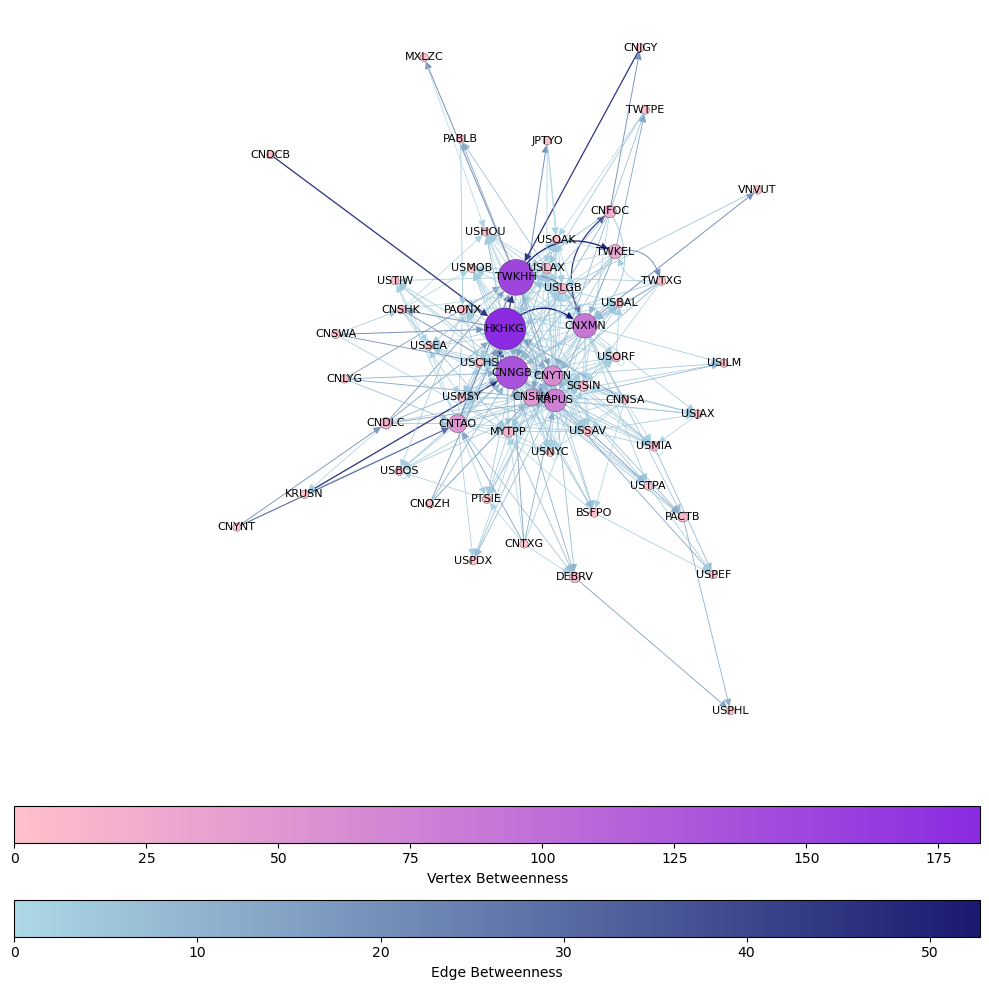

In [15]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs)
#plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs[:, 1])
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_CNHKUSA.png")
plt.show()

Calculate betweenness with weights

In [16]:
#Centrality with weights
vertex_betweenness_weights = ig_G.betweenness(weights="median_time_minutes")
edge_betweenness_weights = ig_G.edge_betweenness(weights="median_time_minutes")

centrality_df_weights = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness_weights, edge_betweenness_weights, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [17]:
centrality_df_weights

port  betweenness  edge_betweenness  in_degree  out_degree  \
0   CNSHA         18.0               0.0          5          27   
1   USOAK          0.0               2.0         13           1   
2   USMOB          0.0               0.0         11           1   
3   USSAV         45.0               0.0         12           4   
4   CNXMN        137.0               4.0          5          26   
5   USLAX         65.5               0.0         14           6   
6   CNYTN         40.0               0.0          8          25   
7   USORF         24.0               0.0         11           2   
8   CNDLC         46.0               0.0          1           7   
9   KRPUS        313.0               0.0         11          22   
10  USBAL          0.0               1.0         10           1   
11  USCHS          4.0               2.0         12           2   
12  USHOU          0.0               0.0         12           1   
13  USJAX         24.0               0.0          6           1   
14  KRUSN          0.0               0.0          2           1   
15  CNNGB        188.0               0.0         11          24   
16  USLGB         44.5               0.0         15           5   
17  USMIA          4.0               0.0         10           2   
18  USMSY          0.0               4.0         10           1   
19  USSEA          0.0               2.0         10           1   
20  USTPA          0.0               0.0          5           1   
21  CNFOC         18.5               3.0          1           8   
22  CNLYG          0.0              30.0          0           4   
23  CNTAO         23.0               0.0          4          20   
24  SGSIN          6.0              11.0         13           6   
25  CNQZH          0.0               0.0          0           4   
26  HKHKG        222.0               3.0         10          22   
27  CNYNT          0.0               0.0          0           2   
28  PTSIE         14.0               0.0          7           1   
29  USBOS          0.0               0.0          7           1   
30  USILM          0.0              48.0          4           0   
31  USNYC          0.0               0.0         12           1   
32  USPDX          0.0               1.0          4           0   
33  BSFPO          0.0               0.0          5           2   
34  USPEF          0.0               0.0          4           0   
35  DEBRV          1.0               0.0          5           1   
36  USPHL          0.0               0.0          2           0   
37  VNVUT          0.0               0.0          1           1   
38  PACTB         22.0               0.0          4           1   
39  CNNSA          0.0              30.5          0          12   
40  MYTPP         64.0               0.0          9           6   
41  CNSHK          0.0               0.0          2           6   
42  CNSWA          0.0              22.0          0           4   
43  CNTXG          0.0               0.0          0           7   
44  TWKHH        347.5               0.0          9          21   
45  TWKEL         86.5              71.0          2          10   
46  TWTXG          0.0               0.0          1           7   
47  CNJGY          0.0               0.0          1           1   
48  JPTYO          0.0              20.0          1           3   
49  TWTPE          0.0               0.0          2           2   
50  PAONX         14.0               0.0          9           3   
51  CNDCB          0.0              37.5          0           1   
52  USTIW          3.0               0.0          5           1   
53  PABLB          0.0               0.0          2           1   
54  MXLZC          0.0               0.0          1           1   

    sum_of_degrees  closeness  
0               32   0.675000  
1               14   0.556701  
2               12   0.540000  
3               16   0.562500  
4               31   0.658537  
5               20   0.586957  
6               33   0.70129

vertices: 0.0 - 347.5
edges: 0.0 - 153.0


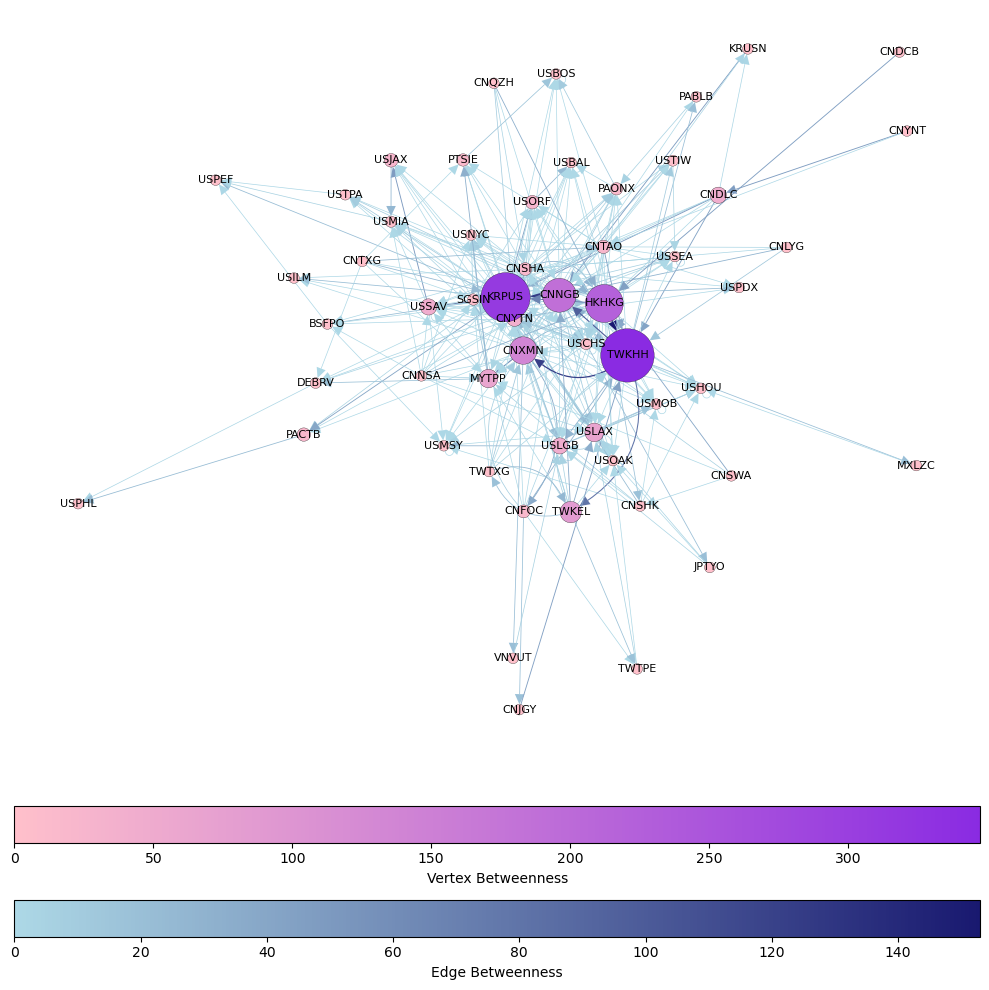

In [18]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness_weights, edge_betweenness_weights, *axs)
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_weights_SA_msc_route.png")
plt.show()

Plot degree

In [19]:
def plot_degree(g, degree, title, ax, cax1):
    '''Plot degree

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the degree colorbar
    '''

    # Rescale degree to be between 0.0 and 1.0
    scaled_degree = ig.rescale(degree, clamp=True)
    print(f"degree: {min(in_degree)} - {max(in_degree)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("degree_cmap", ["pink", "blueviolet"])
    
    # Plot graph
    g.vs["color"] = [cmap1(degree) for degree in scaled_degree]
    g.vs["size"]  = ig.rescale(degree, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords 
        vertex_frame_width=0.2,
    )
    
    ax.set_title(title)

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(degree)), cmap=cmap1)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Degree', shrink=0.5)

In [20]:
in_degree = ig_G.degree(mode="in")
out_degree = ig_G.degree(mode="out")

degree: 0 - 15
degree: 0 - 15


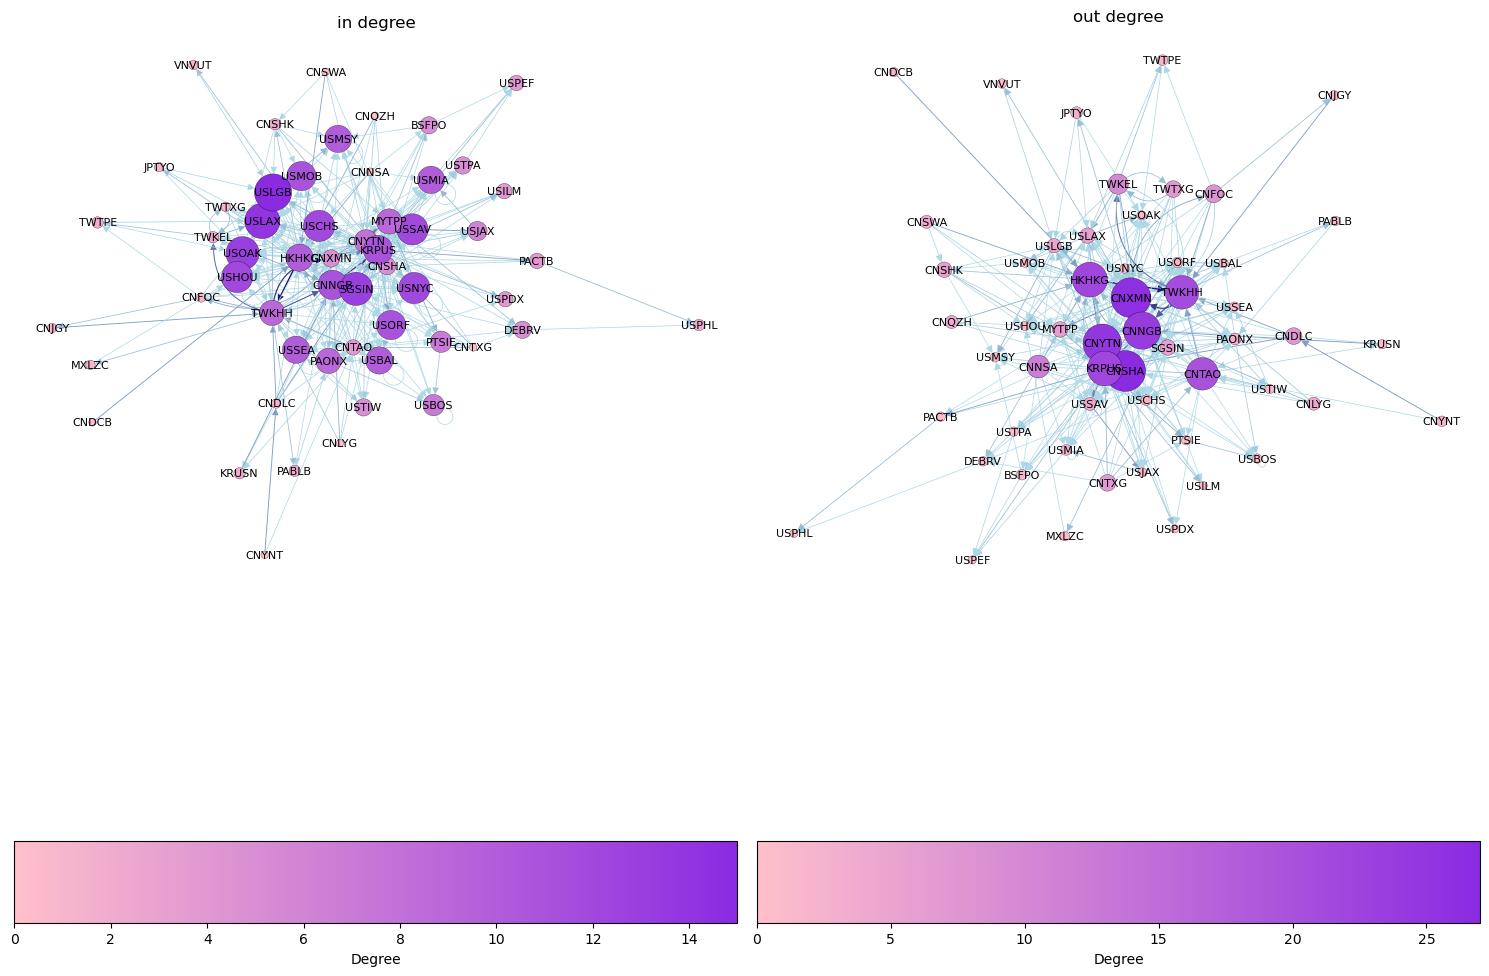

In [21]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(15, 15),
    gridspec_kw=dict(height_ratios=(20, 1)),
)

plot_degree(ig_G, in_degree, "in degree", *axs[:, 0])
plot_degree(ig_G, out_degree, "out degree", *axs[:, 1])
fig.tight_layout(h_pad=1)
plt.savefig("./figure/degree_CNHKUSA_msc_route.png")
plt.show()